In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_CAP_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4014968, 829)
(4014968, 8)
validation
(782336, 829)
(782336, 8)
test
(325224, 829)
(325224, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1539976 (5.87 MB)


Trainable params: 1539976 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/402 [..............................] - ETA: 8:20 - loss: 2.2672 - STD: 0.0538 - MAE: 0.2207

  4/402 [..............................] - ETA: 7s - loss: 2.1257 - STD: 0.0392 - MAE: 0.2181  

  7/402 [..............................] - ETA: 6s - loss: 2.1117 - STD: 0.0522 - MAE: 0.2166

 11/402 [..............................] - ETA: 6s - loss: 2.0946 - STD: 0.0463 - MAE: 0.2166

 15/402 [>.............................] - ETA: 6s - loss: 2.0844 - STD: 0.0399 - MAE: 0.2169

 19/402 [>.............................] - ETA: 6s - loss: 2.0776 - STD: 0.0376 - MAE: 0.2169

 23/402 [>.............................] - ETA: 6s - loss: 2.0702 - STD: 0.0365 - MAE: 0.2168

 27/402 [=>............................] - ETA: 6s - loss: 2.0624 - STD: 0.0367 - MAE: 0.2166

 31/402 [=>............................] - ETA: 6s - loss: 2.0525 - STD: 0.0374 - MAE: 0.2162

 35/402 [=>............................] - ETA: 5s - loss: 2.0406 - STD: 0.0386 - MAE: 0.2158

 39/402 [=>............................] - ETA: 5s - loss: 2.0276 - STD: 0.0407 - MAE: 0.2152

 43/402 [==>...........................] - ETA: 5s - loss: 2.0144 - STD: 0.0434 - MAE: 0.2145

 47/402 [==>...........................] - ETA: 5s - loss: 2.0002 - STD: 0.0460 - MAE: 0.2138

 51/402 [==>...........................] - ETA: 5s - loss: 1.9861 - STD: 0.0484 - MAE: 0.2132

 55/402 [===>..........................] - ETA: 5s - loss: 1.9726 - STD: 0.0508 - MAE: 0.2125

 59/402 [===>..........................] - ETA: 5s - loss: 1.9590 - STD: 0.0530 - MAE: 0.2118

 63/402 [===>..........................] - ETA: 5s - loss: 1.9463 - STD: 0.0552 - MAE: 0.2112

 67/402 [====>.........................] - ETA: 5s - loss: 1.9336 - STD: 0.0572 - MAE: 0.2106

 71/402 [====>.........................] - ETA: 5s - loss: 1.9208 - STD: 0.0591 - MAE: 0.2100

 75/402 [====>.........................] - ETA: 5s - loss: 1.9075 - STD: 0.0610 - MAE: 0.2093

 79/402 [====>.........................] - ETA: 5s - loss: 1.8943 - STD: 0.0630 - MAE: 0.2085

 83/402 [=====>........................] - ETA: 5s - loss: 1.8805 - STD: 0.0651 - MAE: 0.2077

 87/402 [=====>........................] - ETA: 5s - loss: 1.8666 - STD: 0.0673 - MAE: 0.2068

 91/402 [=====>........................] - ETA: 4s - loss: 1.8528 - STD: 0.0696 - MAE: 0.2059

 95/402 [======>.......................] - ETA: 4s - loss: 1.8394 - STD: 0.0719 - MAE: 0.2050

 99/402 [======>.......................] - ETA: 4s - loss: 1.8259 - STD: 0.0741 - MAE: 0.2041

103/402 [======>.......................] - ETA: 4s - loss: 1.8127 - STD: 0.0764 - MAE: 0.2032

107/402 [======>.......................] - ETA: 4s - loss: 1.8002 - STD: 0.0786 - MAE: 0.2023

111/402 [=======>......................] - ETA: 4s - loss: 1.7883 - STD: 0.0808 - MAE: 0.2014

115/402 [=======>......................] - ETA: 4s - loss: 1.7765 - STD: 0.0829 - MAE: 0.2005

119/402 [=======>......................] - ETA: 4s - loss: 1.7654 - STD: 0.0849 - MAE: 0.1997

123/402 [========>.....................] - ETA: 4s - loss: 1.7547 - STD: 0.0868 - MAE: 0.1989

127/402 [========>.....................] - ETA: 4s - loss: 1.7443 - STD: 0.0887 - MAE: 0.1981

131/402 [========>.....................] - ETA: 4s - loss: 1.7346 - STD: 0.0905 - MAE: 0.1974

135/402 [=========>....................] - ETA: 4s - loss: 1.7250 - STD: 0.0922 - MAE: 0.1966

139/402 [=========>....................] - ETA: 4s - loss: 1.7156 - STD: 0.0938 - MAE: 0.1959

143/402 [=========>....................] - ETA: 4s - loss: 1.7066 - STD: 0.0954 - MAE: 0.1952

147/402 [=========>....................] - ETA: 4s - loss: 1.6980 - STD: 0.0970 - MAE: 0.1945

151/402 [==========>...................] - ETA: 3s - loss: 1.6897 - STD: 0.0984 - MAE: 0.1939

155/402 [==========>...................] - ETA: 3s - loss: 1.6815 - STD: 0.0999 - MAE: 0.1932

159/402 [==========>...................] - ETA: 3s - loss: 1.6735 - STD: 0.1013 - MAE: 0.1926

163/402 [===========>..................] - ETA: 3s - loss: 1.6661 - STD: 0.1026 - MAE: 0.1920

167/402 [===========>..................] - ETA: 3s - loss: 1.6589 - STD: 0.1039 - MAE: 0.1914

171/402 [===========>..................] - ETA: 3s - loss: 1.6522 - STD: 0.1052 - MAE: 0.1909

175/402 [============>.................] - ETA: 3s - loss: 1.6454 - STD: 0.1064 - MAE: 0.1904

179/402 [============>.................] - ETA: 3s - loss: 1.6389 - STD: 0.1075 - MAE: 0.1898

183/402 [============>.................] - ETA: 3s - loss: 1.6326 - STD: 0.1086 - MAE: 0.1893

187/402 [============>.................] - ETA: 3s - loss: 1.6263 - STD: 0.1098 - MAE: 0.1888

191/402 [=============>................] - ETA: 3s - loss: 1.6203 - STD: 0.1108 - MAE: 0.1883

195/402 [=============>................] - ETA: 3s - loss: 1.6146 - STD: 0.1119 - MAE: 0.1878

199/402 [=============>................] - ETA: 3s - loss: 1.6095 - STD: 0.1129 - MAE: 0.1874

203/402 [==============>...............] - ETA: 3s - loss: 1.6045 - STD: 0.1138 - MAE: 0.1870

207/402 [==============>...............] - ETA: 3s - loss: 1.5992 - STD: 0.1148 - MAE: 0.1865

211/402 [==============>...............] - ETA: 3s - loss: 1.5943 - STD: 0.1157 - MAE: 0.1861

215/402 [===============>..............] - ETA: 2s - loss: 1.5892 - STD: 0.1165 - MAE: 0.1857

219/402 [===============>..............] - ETA: 2s - loss: 1.5843 - STD: 0.1174 - MAE: 0.1853

223/402 [===============>..............] - ETA: 2s - loss: 1.5795 - STD: 0.1182 - MAE: 0.1849

227/402 [===============>..............] - ETA: 2s - loss: 1.5750 - STD: 0.1191 - MAE: 0.1845

231/402 [================>.............] - ETA: 2s - loss: 1.5706 - STD: 0.1199 - MAE: 0.1842

235/402 [================>.............] - ETA: 2s - loss: 1.5663 - STD: 0.1206 - MAE: 0.1838

239/402 [================>.............] - ETA: 2s - loss: 1.5620 - STD: 0.1214 - MAE: 0.1835

243/402 [=================>............] - ETA: 2s - loss: 1.5579 - STD: 0.1221 - MAE: 0.1831

247/402 [=================>............] - ETA: 2s - loss: 1.5539 - STD: 0.1229 - MAE: 0.1828

251/402 [=================>............] - ETA: 2s - loss: 1.5499 - STD: 0.1235 - MAE: 0.1824

255/402 [==================>...........] - ETA: 2s - loss: 1.5460 - STD: 0.1242 - MAE: 0.1821

259/402 [==================>...........] - ETA: 2s - loss: 1.5420 - STD: 0.1249 - MAE: 0.1818

263/402 [==================>...........] - ETA: 2s - loss: 1.5382 - STD: 0.1256 - MAE: 0.1815

267/402 [==================>...........] - ETA: 2s - loss: 1.5344 - STD: 0.1262 - MAE: 0.1811

271/402 [===================>..........] - ETA: 2s - loss: 1.5307 - STD: 0.1268 - MAE: 0.1808

275/402 [===================>..........] - ETA: 2s - loss: 1.5272 - STD: 0.1275 - MAE: 0.1805

279/402 [===================>..........] - ETA: 1s - loss: 1.5236 - STD: 0.1281 - MAE: 0.1802

283/402 [====================>.........] - ETA: 1s - loss: 1.5202 - STD: 0.1287 - MAE: 0.1799

287/402 [====================>.........] - ETA: 1s - loss: 1.5169 - STD: 0.1293 - MAE: 0.1796

291/402 [====================>.........] - ETA: 1s - loss: 1.5137 - STD: 0.1298 - MAE: 0.1794

295/402 [=====================>........] - ETA: 1s - loss: 1.5105 - STD: 0.1304 - MAE: 0.1791

299/402 [=====================>........] - ETA: 1s - loss: 1.5076 - STD: 0.1309 - MAE: 0.1788

303/402 [=====================>........] - ETA: 1s - loss: 1.5046 - STD: 0.1315 - MAE: 0.1786

307/402 [=====================>........] - ETA: 1s - loss: 1.5017 - STD: 0.1320 - MAE: 0.1783

311/402 [======================>.......] - ETA: 1s - loss: 1.4989 - STD: 0.1325 - MAE: 0.1781

315/402 [======================>.......] - ETA: 1s - loss: 1.4960 - STD: 0.1330 - MAE: 0.1778

319/402 [======================>.......] - ETA: 1s - loss: 1.4932 - STD: 0.1335 - MAE: 0.1776

323/402 [=======================>......] - ETA: 1s - loss: 1.4902 - STD: 0.1340 - MAE: 0.1773

327/402 [=======================>......] - ETA: 1s - loss: 1.4875 - STD: 0.1345 - MAE: 0.1771

331/402 [=======================>......] - ETA: 1s - loss: 1.4847 - STD: 0.1349 - MAE: 0.1769

335/402 [========================>.....] - ETA: 1s - loss: 1.4819 - STD: 0.1354 - MAE: 0.1766

339/402 [========================>.....] - ETA: 1s - loss: 1.4792 - STD: 0.1358 - MAE: 0.1764

343/402 [========================>.....] - ETA: 0s - loss: 1.4764 - STD: 0.1363 - MAE: 0.1762

347/402 [========================>.....] - ETA: 0s - loss: 1.4737 - STD: 0.1367 - MAE: 0.1759

351/402 [=========================>....] - ETA: 0s - loss: 1.4713 - STD: 0.1372 - MAE: 0.1757

355/402 [=========================>....] - ETA: 0s - loss: 1.4687 - STD: 0.1376 - MAE: 0.1755

359/402 [=========================>....] - ETA: 0s - loss: 1.4662 - STD: 0.1380 - MAE: 0.1753

363/402 [==========================>...] - ETA: 0s - loss: 1.4636 - STD: 0.1385 - MAE: 0.1750

367/402 [==========================>...] - ETA: 0s - loss: 1.4614 - STD: 0.1389 - MAE: 0.1748

371/402 [==========================>...] - ETA: 0s - loss: 1.4590 - STD: 0.1393 - MAE: 0.1746

372/402 [==========================>...] - ETA: 0s - loss: 1.4587 - STD: 0.1394 - MAE: 0.1746

376/402 [===========================>..] - ETA: 0s - loss: 1.4563 - STD: 0.1398 - MAE: 0.1744

380/402 [===========================>..] - ETA: 0s - loss: 1.4540 - STD: 0.1401 - MAE: 0.1742

384/402 [===========================>..] - ETA: 0s - loss: 1.4516 - STD: 0.1405 - MAE: 0.1740

388/402 [===========================>..] - ETA: 0s - loss: 1.4492 - STD: 0.1409 - MAE: 0.1738

392/402 [============================>.] - ETA: 0s - loss: 1.4469 - STD: 0.1413 - MAE: 0.1735

396/402 [============================>.] - ETA: 0s - loss: 1.4447 - STD: 0.1417 - MAE: 0.1733

400/402 [============================>.] - ETA: 0s - loss: 1.4424 - STD: 0.1420 - MAE: 0.1732

402/402 [==============================] - 10s 22ms/step - loss: 1.4412 - STD: 0.1422 - MAE: 0.1731 - val_loss: 1.2829 - val_STD: 0.1742 - val_MAE: 0.1589


Epoch 2/10000


  1/402 [..............................] - ETA: 16s - loss: 1.2181 - STD: 0.1774 - MAE: 0.1540

  4/402 [..............................] - ETA: 6s - loss: 1.2376 - STD: 0.1788 - MAE: 0.1542 

  8/402 [..............................] - ETA: 6s - loss: 1.2427 - STD: 0.1791 - MAE: 0.1544

 12/402 [..............................] - ETA: 6s - loss: 1.2468 - STD: 0.1791 - MAE: 0.1546

 16/402 [>.............................] - ETA: 6s - loss: 1.2440 - STD: 0.1784 - MAE: 0.1547

 20/402 [>.............................] - ETA: 6s - loss: 1.2400 - STD: 0.1781 - MAE: 0.1547

 24/402 [>.............................] - ETA: 5s - loss: 1.2374 - STD: 0.1781 - MAE: 0.1546

 28/402 [=>............................] - ETA: 5s - loss: 1.2353 - STD: 0.1782 - MAE: 0.1544

 32/402 [=>............................] - ETA: 5s - loss: 1.2321 - STD: 0.1782 - MAE: 0.1543

 36/402 [=>............................] - ETA: 5s - loss: 1.2314 - STD: 0.1784 - MAE: 0.1542

 39/402 [=>............................] - ETA: 5s - loss: 1.2301 - STD: 0.1785 - MAE: 0.1541

 43/402 [==>...........................] - ETA: 5s - loss: 1.2288 - STD: 0.1786 - MAE: 0.1540

 47/402 [==>...........................] - ETA: 5s - loss: 1.2274 - STD: 0.1788 - MAE: 0.1539

 51/402 [==>...........................] - ETA: 5s - loss: 1.2255 - STD: 0.1789 - MAE: 0.1537

 55/402 [===>..........................] - ETA: 5s - loss: 1.2241 - STD: 0.1791 - MAE: 0.1536

 59/402 [===>..........................] - ETA: 5s - loss: 1.2227 - STD: 0.1792 - MAE: 0.1535

 63/402 [===>..........................] - ETA: 5s - loss: 1.2222 - STD: 0.1793 - MAE: 0.1534

 67/402 [====>.........................] - ETA: 5s - loss: 1.2208 - STD: 0.1793 - MAE: 0.1534

 71/402 [====>.........................] - ETA: 5s - loss: 1.2192 - STD: 0.1794 - MAE: 0.1532

 75/402 [====>.........................] - ETA: 5s - loss: 1.2183 - STD: 0.1795 - MAE: 0.1532

 79/402 [====>.........................] - ETA: 5s - loss: 1.2173 - STD: 0.1797 - MAE: 0.1531

 83/402 [=====>........................] - ETA: 4s - loss: 1.2160 - STD: 0.1798 - MAE: 0.1530

 87/402 [=====>........................] - ETA: 4s - loss: 1.2145 - STD: 0.1800 - MAE: 0.1528

 91/402 [=====>........................] - ETA: 4s - loss: 1.2132 - STD: 0.1801 - MAE: 0.1527

 95/402 [======>.......................] - ETA: 4s - loss: 1.2127 - STD: 0.1802 - MAE: 0.1527

 99/402 [======>.......................] - ETA: 4s - loss: 1.2121 - STD: 0.1803 - MAE: 0.1526

103/402 [======>.......................] - ETA: 4s - loss: 1.2109 - STD: 0.1804 - MAE: 0.1525

107/402 [======>.......................] - ETA: 4s - loss: 1.2098 - STD: 0.1805 - MAE: 0.1525

111/402 [=======>......................] - ETA: 4s - loss: 1.2086 - STD: 0.1806 - MAE: 0.1524

115/402 [=======>......................] - ETA: 4s - loss: 1.2076 - STD: 0.1807 - MAE: 0.1523

119/402 [=======>......................] - ETA: 4s - loss: 1.2071 - STD: 0.1807 - MAE: 0.1522

123/402 [========>.....................] - ETA: 4s - loss: 1.2071 - STD: 0.1809 - MAE: 0.1522

127/402 [========>.....................] - ETA: 4s - loss: 1.2074 - STD: 0.1810 - MAE: 0.1522

131/402 [========>.....................] - ETA: 4s - loss: 1.2074 - STD: 0.1810 - MAE: 0.1521

135/402 [=========>....................] - ETA: 4s - loss: 1.2067 - STD: 0.1811 - MAE: 0.1521

139/402 [=========>....................] - ETA: 4s - loss: 1.2065 - STD: 0.1811 - MAE: 0.1521

142/402 [=========>....................] - ETA: 4s - loss: 1.2060 - STD: 0.1812 - MAE: 0.1520

146/402 [=========>....................] - ETA: 4s - loss: 1.2052 - STD: 0.1812 - MAE: 0.1520

150/402 [==========>...................] - ETA: 3s - loss: 1.2046 - STD: 0.1813 - MAE: 0.1519

154/402 [==========>...................] - ETA: 3s - loss: 1.2042 - STD: 0.1814 - MAE: 0.1519

158/402 [==========>...................] - ETA: 3s - loss: 1.2035 - STD: 0.1815 - MAE: 0.1518

162/402 [===========>..................] - ETA: 3s - loss: 1.2029 - STD: 0.1815 - MAE: 0.1517

166/402 [===========>..................] - ETA: 3s - loss: 1.2021 - STD: 0.1816 - MAE: 0.1517

170/402 [===========>..................] - ETA: 3s - loss: 1.2010 - STD: 0.1817 - MAE: 0.1516

174/402 [===========>..................] - ETA: 3s - loss: 1.1999 - STD: 0.1818 - MAE: 0.1515

178/402 [============>.................] - ETA: 3s - loss: 1.1992 - STD: 0.1819 - MAE: 0.1514

182/402 [============>.................] - ETA: 3s - loss: 1.1984 - STD: 0.1820 - MAE: 0.1514

186/402 [============>.................] - ETA: 3s - loss: 1.1975 - STD: 0.1821 - MAE: 0.1513

190/402 [=============>................] - ETA: 3s - loss: 1.1965 - STD: 0.1822 - MAE: 0.1512

194/402 [=============>................] - ETA: 3s - loss: 1.1957 - STD: 0.1823 - MAE: 0.1511

198/402 [=============>................] - ETA: 3s - loss: 1.1950 - STD: 0.1824 - MAE: 0.1510

202/402 [==============>...............] - ETA: 3s - loss: 1.1943 - STD: 0.1825 - MAE: 0.1510

206/402 [==============>...............] - ETA: 3s - loss: 1.1934 - STD: 0.1826 - MAE: 0.1509

210/402 [==============>...............] - ETA: 3s - loss: 1.1927 - STD: 0.1826 - MAE: 0.1508

214/402 [==============>...............] - ETA: 2s - loss: 1.1926 - STD: 0.1827 - MAE: 0.1508

218/402 [===============>..............] - ETA: 2s - loss: 1.1921 - STD: 0.1828 - MAE: 0.1507

222/402 [===============>..............] - ETA: 2s - loss: 1.1916 - STD: 0.1829 - MAE: 0.1507

226/402 [===============>..............] - ETA: 2s - loss: 1.1909 - STD: 0.1830 - MAE: 0.1506

230/402 [================>.............] - ETA: 2s - loss: 1.1903 - STD: 0.1830 - MAE: 0.1506

234/402 [================>.............] - ETA: 2s - loss: 1.1897 - STD: 0.1831 - MAE: 0.1505

238/402 [================>.............] - ETA: 2s - loss: 1.1889 - STD: 0.1832 - MAE: 0.1504

242/402 [=================>............] - ETA: 2s - loss: 1.1882 - STD: 0.1833 - MAE: 0.1504

246/402 [=================>............] - ETA: 2s - loss: 1.1873 - STD: 0.1833 - MAE: 0.1503

250/402 [=================>............] - ETA: 2s - loss: 1.1867 - STD: 0.1834 - MAE: 0.1502

254/402 [=================>............] - ETA: 2s - loss: 1.1860 - STD: 0.1835 - MAE: 0.1502

258/402 [==================>...........] - ETA: 2s - loss: 1.1854 - STD: 0.1836 - MAE: 0.1501

262/402 [==================>...........] - ETA: 2s - loss: 1.1850 - STD: 0.1837 - MAE: 0.1501

266/402 [==================>...........] - ETA: 2s - loss: 1.1845 - STD: 0.1838 - MAE: 0.1500

270/402 [===================>..........] - ETA: 2s - loss: 1.1836 - STD: 0.1838 - MAE: 0.1499

274/402 [===================>..........] - ETA: 2s - loss: 1.1829 - STD: 0.1839 - MAE: 0.1499

278/402 [===================>..........] - ETA: 1s - loss: 1.1822 - STD: 0.1840 - MAE: 0.1498

282/402 [====================>.........] - ETA: 1s - loss: 1.1815 - STD: 0.1841 - MAE: 0.1497

286/402 [====================>.........] - ETA: 1s - loss: 1.1808 - STD: 0.1842 - MAE: 0.1497

290/402 [====================>.........] - ETA: 1s - loss: 1.1802 - STD: 0.1843 - MAE: 0.1496

294/402 [====================>.........] - ETA: 1s - loss: 1.1799 - STD: 0.1844 - MAE: 0.1496

298/402 [=====================>........] - ETA: 1s - loss: 1.1795 - STD: 0.1844 - MAE: 0.1495

302/402 [=====================>........] - ETA: 1s - loss: 1.1793 - STD: 0.1845 - MAE: 0.1495

306/402 [=====================>........] - ETA: 1s - loss: 1.1789 - STD: 0.1846 - MAE: 0.1494

310/402 [======================>.......] - ETA: 1s - loss: 1.1785 - STD: 0.1846 - MAE: 0.1494

314/402 [======================>.......] - ETA: 1s - loss: 1.1780 - STD: 0.1847 - MAE: 0.1493

317/402 [======================>.......] - ETA: 1s - loss: 1.1775 - STD: 0.1847 - MAE: 0.1493

321/402 [======================>.......] - ETA: 1s - loss: 1.1768 - STD: 0.1848 - MAE: 0.1492

325/402 [=======================>......] - ETA: 1s - loss: 1.1761 - STD: 0.1849 - MAE: 0.1492

329/402 [=======================>......] - ETA: 1s - loss: 1.1754 - STD: 0.1850 - MAE: 0.1491

333/402 [=======================>......] - ETA: 1s - loss: 1.1748 - STD: 0.1850 - MAE: 0.1490

337/402 [========================>.....] - ETA: 1s - loss: 1.1743 - STD: 0.1851 - MAE: 0.1490

340/402 [========================>.....] - ETA: 0s - loss: 1.1738 - STD: 0.1852 - MAE: 0.1489

344/402 [========================>.....] - ETA: 0s - loss: 1.1734 - STD: 0.1853 - MAE: 0.1489

347/402 [========================>.....] - ETA: 0s - loss: 1.1730 - STD: 0.1853 - MAE: 0.1489

351/402 [=========================>....] - ETA: 0s - loss: 1.1726 - STD: 0.1854 - MAE: 0.1488

355/402 [=========================>....] - ETA: 0s - loss: 1.1721 - STD: 0.1855 - MAE: 0.1488

359/402 [=========================>....] - ETA: 0s - loss: 1.1717 - STD: 0.1855 - MAE: 0.1487

363/402 [==========================>...] - ETA: 0s - loss: 1.1712 - STD: 0.1856 - MAE: 0.1486

367/402 [==========================>...] - ETA: 0s - loss: 1.1705 - STD: 0.1856 - MAE: 0.1486

371/402 [==========================>...] - ETA: 0s - loss: 1.1700 - STD: 0.1857 - MAE: 0.1485

375/402 [==========================>...] - ETA: 0s - loss: 1.1693 - STD: 0.1858 - MAE: 0.1485

379/402 [===========================>..] - ETA: 0s - loss: 1.1688 - STD: 0.1859 - MAE: 0.1484

383/402 [===========================>..] - ETA: 0s - loss: 1.1683 - STD: 0.1860 - MAE: 0.1484

387/402 [===========================>..] - ETA: 0s - loss: 1.1678 - STD: 0.1860 - MAE: 0.1483

391/402 [============================>.] - ETA: 0s - loss: 1.1674 - STD: 0.1861 - MAE: 0.1483

395/402 [============================>.] - ETA: 0s - loss: 1.1669 - STD: 0.1862 - MAE: 0.1482

399/402 [============================>.] - ETA: 0s - loss: 1.1663 - STD: 0.1862 - MAE: 0.1482

402/402 [==============================] - 8s 19ms/step - loss: 1.1659 - STD: 0.1863 - MAE: 0.1481 - val_loss: 1.3343 - val_STD: 0.1854 - val_MAE: 0.1563


Epoch 3/10000


  1/402 [..............................] - ETA: 16s - loss: 1.0972 - STD: 0.1936 - MAE: 0.1418

  5/402 [..............................] - ETA: 6s - loss: 1.1220 - STD: 0.1939 - MAE: 0.1430 

  9/402 [..............................] - ETA: 6s - loss: 1.1217 - STD: 0.1936 - MAE: 0.1431

 13/402 [..............................] - ETA: 6s - loss: 1.1148 - STD: 0.1935 - MAE: 0.1427

 17/402 [>.............................] - ETA: 6s - loss: 1.1107 - STD: 0.1934 - MAE: 0.1425

 21/402 [>.............................] - ETA: 6s - loss: 1.1090 - STD: 0.1937 - MAE: 0.1423

 25/402 [>.............................] - ETA: 6s - loss: 1.1069 - STD: 0.1939 - MAE: 0.1421

 29/402 [=>............................] - ETA: 5s - loss: 1.1073 - STD: 0.1941 - MAE: 0.1421

 33/402 [=>............................] - ETA: 5s - loss: 1.1079 - STD: 0.1941 - MAE: 0.1421

 37/402 [=>............................] - ETA: 5s - loss: 1.1075 - STD: 0.1942 - MAE: 0.1421

 41/402 [==>...........................] - ETA: 5s - loss: 1.1067 - STD: 0.1943 - MAE: 0.1419

 45/402 [==>...........................] - ETA: 5s - loss: 1.1056 - STD: 0.1943 - MAE: 0.1419

 49/402 [==>...........................] - ETA: 5s - loss: 1.1050 - STD: 0.1944 - MAE: 0.1418

 53/402 [==>...........................] - ETA: 5s - loss: 1.1041 - STD: 0.1945 - MAE: 0.1417

 57/402 [===>..........................] - ETA: 5s - loss: 1.1041 - STD: 0.1946 - MAE: 0.1417

 61/402 [===>..........................] - ETA: 5s - loss: 1.1035 - STD: 0.1946 - MAE: 0.1417

 65/402 [===>..........................] - ETA: 5s - loss: 1.1039 - STD: 0.1947 - MAE: 0.1416

 69/402 [====>.........................] - ETA: 5s - loss: 1.1041 - STD: 0.1948 - MAE: 0.1416

 73/402 [====>.........................] - ETA: 5s - loss: 1.1054 - STD: 0.1948 - MAE: 0.1417

 77/402 [====>.........................] - ETA: 5s - loss: 1.1050 - STD: 0.1948 - MAE: 0.1417

 81/402 [=====>........................] - ETA: 5s - loss: 1.1039 - STD: 0.1949 - MAE: 0.1416

 85/402 [=====>........................] - ETA: 5s - loss: 1.1034 - STD: 0.1949 - MAE: 0.1416

 89/402 [=====>........................] - ETA: 5s - loss: 1.1026 - STD: 0.1950 - MAE: 0.1415

 93/402 [=====>........................] - ETA: 4s - loss: 1.1023 - STD: 0.1950 - MAE: 0.1415

 97/402 [======>.......................] - ETA: 4s - loss: 1.1028 - STD: 0.1951 - MAE: 0.1415

101/402 [======>.......................] - ETA: 4s - loss: 1.1034 - STD: 0.1952 - MAE: 0.1415

105/402 [======>.......................] - ETA: 4s - loss: 1.1036 - STD: 0.1952 - MAE: 0.1415

109/402 [=======>......................] - ETA: 4s - loss: 1.1036 - STD: 0.1952 - MAE: 0.1415

113/402 [=======>......................] - ETA: 4s - loss: 1.1032 - STD: 0.1952 - MAE: 0.1414

116/402 [=======>......................] - ETA: 4s - loss: 1.1026 - STD: 0.1952 - MAE: 0.1414

120/402 [=======>......................] - ETA: 4s - loss: 1.1016 - STD: 0.1953 - MAE: 0.1413

124/402 [========>.....................] - ETA: 4s - loss: 1.1007 - STD: 0.1954 - MAE: 0.1412

128/402 [========>.....................] - ETA: 4s - loss: 1.1000 - STD: 0.1954 - MAE: 0.1412

132/402 [========>.....................] - ETA: 4s - loss: 1.0992 - STD: 0.1955 - MAE: 0.1411

136/402 [=========>....................] - ETA: 4s - loss: 1.0985 - STD: 0.1956 - MAE: 0.1411

140/402 [=========>....................] - ETA: 4s - loss: 1.0977 - STD: 0.1956 - MAE: 0.1410

144/402 [=========>....................] - ETA: 4s - loss: 1.0968 - STD: 0.1957 - MAE: 0.1409

148/402 [==========>...................] - ETA: 4s - loss: 1.0962 - STD: 0.1958 - MAE: 0.1408

152/402 [==========>...................] - ETA: 4s - loss: 1.0958 - STD: 0.1959 - MAE: 0.1408

156/402 [==========>...................] - ETA: 3s - loss: 1.0953 - STD: 0.1959 - MAE: 0.1407

160/402 [==========>...................] - ETA: 3s - loss: 1.0947 - STD: 0.1960 - MAE: 0.1407

164/402 [===========>..................] - ETA: 3s - loss: 1.0942 - STD: 0.1961 - MAE: 0.1406

168/402 [===========>..................] - ETA: 3s - loss: 1.0937 - STD: 0.1961 - MAE: 0.1406

172/402 [===========>..................] - ETA: 3s - loss: 1.0934 - STD: 0.1962 - MAE: 0.1405

176/402 [============>.................] - ETA: 3s - loss: 1.0931 - STD: 0.1962 - MAE: 0.1405

180/402 [============>.................] - ETA: 3s - loss: 1.0928 - STD: 0.1963 - MAE: 0.1404

184/402 [============>.................] - ETA: 3s - loss: 1.0926 - STD: 0.1964 - MAE: 0.1404

188/402 [=============>................] - ETA: 3s - loss: 1.0921 - STD: 0.1964 - MAE: 0.1404

192/402 [=============>................] - ETA: 3s - loss: 1.0918 - STD: 0.1965 - MAE: 0.1403

196/402 [=============>................] - ETA: 3s - loss: 1.0915 - STD: 0.1966 - MAE: 0.1403

200/402 [=============>................] - ETA: 3s - loss: 1.0914 - STD: 0.1966 - MAE: 0.1403

204/402 [==============>...............] - ETA: 3s - loss: 1.0912 - STD: 0.1966 - MAE: 0.1402

208/402 [==============>...............] - ETA: 3s - loss: 1.0907 - STD: 0.1967 - MAE: 0.1402

211/402 [==============>...............] - ETA: 3s - loss: 1.0904 - STD: 0.1967 - MAE: 0.1401

215/402 [===============>..............] - ETA: 3s - loss: 1.0901 - STD: 0.1968 - MAE: 0.1401

219/402 [===============>..............] - ETA: 2s - loss: 1.0898 - STD: 0.1968 - MAE: 0.1401

223/402 [===============>..............] - ETA: 2s - loss: 1.0895 - STD: 0.1969 - MAE: 0.1400

227/402 [===============>..............] - ETA: 2s - loss: 1.0892 - STD: 0.1969 - MAE: 0.1400

231/402 [================>.............] - ETA: 2s - loss: 1.0886 - STD: 0.1970 - MAE: 0.1400

234/402 [================>.............] - ETA: 2s - loss: 1.0882 - STD: 0.1970 - MAE: 0.1399

238/402 [================>.............] - ETA: 2s - loss: 1.0876 - STD: 0.1971 - MAE: 0.1399

242/402 [=================>............] - ETA: 2s - loss: 1.0874 - STD: 0.1971 - MAE: 0.1398

246/402 [=================>............] - ETA: 2s - loss: 1.0872 - STD: 0.1972 - MAE: 0.1398

249/402 [=================>............] - ETA: 2s - loss: 1.0869 - STD: 0.1972 - MAE: 0.1398

253/402 [=================>............] - ETA: 2s - loss: 1.0866 - STD: 0.1973 - MAE: 0.1397

257/402 [==================>...........] - ETA: 2s - loss: 1.0864 - STD: 0.1973 - MAE: 0.1397

261/402 [==================>...........] - ETA: 2s - loss: 1.0858 - STD: 0.1974 - MAE: 0.1396

264/402 [==================>...........] - ETA: 2s - loss: 1.0854 - STD: 0.1974 - MAE: 0.1396

268/402 [===================>..........] - ETA: 2s - loss: 1.0851 - STD: 0.1975 - MAE: 0.1396

272/402 [===================>..........] - ETA: 2s - loss: 1.0847 - STD: 0.1975 - MAE: 0.1395

276/402 [===================>..........] - ETA: 2s - loss: 1.0842 - STD: 0.1975 - MAE: 0.1395

280/402 [===================>..........] - ETA: 1s - loss: 1.0840 - STD: 0.1976 - MAE: 0.1395

284/402 [====================>.........] - ETA: 1s - loss: 1.0836 - STD: 0.1976 - MAE: 0.1394

287/402 [====================>.........] - ETA: 1s - loss: 1.0831 - STD: 0.1977 - MAE: 0.1394

291/402 [====================>.........] - ETA: 1s - loss: 1.0827 - STD: 0.1977 - MAE: 0.1393

295/402 [=====================>........] - ETA: 1s - loss: 1.0824 - STD: 0.1978 - MAE: 0.1393

299/402 [=====================>........] - ETA: 1s - loss: 1.0819 - STD: 0.1978 - MAE: 0.1392

303/402 [=====================>........] - ETA: 1s - loss: 1.0817 - STD: 0.1979 - MAE: 0.1392

306/402 [=====================>........] - ETA: 1s - loss: 1.0819 - STD: 0.1979 - MAE: 0.1392

310/402 [======================>.......] - ETA: 1s - loss: 1.0821 - STD: 0.1980 - MAE: 0.1392

314/402 [======================>.......] - ETA: 1s - loss: 1.0821 - STD: 0.1980 - MAE: 0.1392

318/402 [======================>.......] - ETA: 1s - loss: 1.0819 - STD: 0.1981 - MAE: 0.1391

322/402 [=======================>......] - ETA: 1s - loss: 1.0815 - STD: 0.1981 - MAE: 0.1391

326/402 [=======================>......] - ETA: 1s - loss: 1.0814 - STD: 0.1981 - MAE: 0.1391

330/402 [=======================>......] - ETA: 1s - loss: 1.0811 - STD: 0.1982 - MAE: 0.1390

334/402 [=======================>......] - ETA: 1s - loss: 1.0808 - STD: 0.1982 - MAE: 0.1390

338/402 [========================>.....] - ETA: 1s - loss: 1.0807 - STD: 0.1983 - MAE: 0.1390

342/402 [========================>.....] - ETA: 0s - loss: 1.0804 - STD: 0.1983 - MAE: 0.1390

346/402 [========================>.....] - ETA: 0s - loss: 1.0800 - STD: 0.1983 - MAE: 0.1389

350/402 [=========================>....] - ETA: 0s - loss: 1.0798 - STD: 0.1984 - MAE: 0.1389

354/402 [=========================>....] - ETA: 0s - loss: 1.0793 - STD: 0.1984 - MAE: 0.1388

358/402 [=========================>....] - ETA: 0s - loss: 1.0790 - STD: 0.1985 - MAE: 0.1388

362/402 [==========================>...] - ETA: 0s - loss: 1.0785 - STD: 0.1985 - MAE: 0.1388

366/402 [==========================>...] - ETA: 0s - loss: 1.0781 - STD: 0.1986 - MAE: 0.1387

370/402 [==========================>...] - ETA: 0s - loss: 1.0778 - STD: 0.1986 - MAE: 0.1387

374/402 [==========================>...] - ETA: 0s - loss: 1.0776 - STD: 0.1987 - MAE: 0.1387

378/402 [===========================>..] - ETA: 0s - loss: 1.0772 - STD: 0.1987 - MAE: 0.1386

382/402 [===========================>..] - ETA: 0s - loss: 1.0769 - STD: 0.1987 - MAE: 0.1386

386/402 [===========================>..] - ETA: 0s - loss: 1.0765 - STD: 0.1988 - MAE: 0.1385

390/402 [============================>.] - ETA: 0s - loss: 1.0762 - STD: 0.1988 - MAE: 0.1385

394/402 [============================>.] - ETA: 0s - loss: 1.0758 - STD: 0.1989 - MAE: 0.1385

397/402 [============================>.] - ETA: 0s - loss: 1.0755 - STD: 0.1989 - MAE: 0.1384

401/402 [============================>.] - ETA: 0s - loss: 1.0752 - STD: 0.1990 - MAE: 0.1384

402/402 [==============================] - 8s 19ms/step - loss: 1.0751 - STD: 0.1990 - MAE: 0.1384 - val_loss: 1.3901 - val_STD: 0.1943 - val_MAE: 0.1546


Epoch 4/10000


  1/402 [..............................] - ETA: 17s - loss: 1.0689 - STD: 0.2022 - MAE: 0.1368

  4/402 [..............................] - ETA: 6s - loss: 1.0491 - STD: 0.2029 - MAE: 0.1354 

  8/402 [..............................] - ETA: 6s - loss: 1.0493 - STD: 0.2032 - MAE: 0.1352

 12/402 [..............................] - ETA: 6s - loss: 1.0431 - STD: 0.2034 - MAE: 0.1348

 16/402 [>.............................] - ETA: 6s - loss: 1.0384 - STD: 0.2038 - MAE: 0.1343

 19/402 [>.............................] - ETA: 6s - loss: 1.0400 - STD: 0.2037 - MAE: 0.1344

 23/402 [>.............................] - ETA: 6s - loss: 1.0424 - STD: 0.2036 - MAE: 0.1346

 27/402 [=>............................] - ETA: 6s - loss: 1.0407 - STD: 0.2037 - MAE: 0.1345

 31/402 [=>............................] - ETA: 6s - loss: 1.0394 - STD: 0.2037 - MAE: 0.1344

 35/402 [=>............................] - ETA: 6s - loss: 1.0379 - STD: 0.2037 - MAE: 0.1343

 39/402 [=>............................] - ETA: 5s - loss: 1.0360 - STD: 0.2038 - MAE: 0.1342

 43/402 [==>...........................] - ETA: 5s - loss: 1.0344 - STD: 0.2039 - MAE: 0.1341

 47/402 [==>...........................] - ETA: 5s - loss: 1.0338 - STD: 0.2040 - MAE: 0.1340

 51/402 [==>...........................] - ETA: 5s - loss: 1.0333 - STD: 0.2041 - MAE: 0.1339

 54/402 [===>..........................] - ETA: 5s - loss: 1.0324 - STD: 0.2041 - MAE: 0.1339

 57/402 [===>..........................] - ETA: 5s - loss: 1.0338 - STD: 0.2041 - MAE: 0.1340

 61/402 [===>..........................] - ETA: 5s - loss: 1.0338 - STD: 0.2042 - MAE: 0.1340

 65/402 [===>..........................] - ETA: 5s - loss: 1.0336 - STD: 0.2041 - MAE: 0.1339

 69/402 [====>.........................] - ETA: 5s - loss: 1.0341 - STD: 0.2042 - MAE: 0.1340

 73/402 [====>.........................] - ETA: 5s - loss: 1.0346 - STD: 0.2043 - MAE: 0.1339

 76/402 [====>.........................] - ETA: 5s - loss: 1.0358 - STD: 0.2043 - MAE: 0.1340

 79/402 [====>.........................] - ETA: 5s - loss: 1.0374 - STD: 0.2043 - MAE: 0.1341

 83/402 [=====>........................] - ETA: 5s - loss: 1.0381 - STD: 0.2043 - MAE: 0.1341

 87/402 [=====>........................] - ETA: 5s - loss: 1.0391 - STD: 0.2043 - MAE: 0.1342

 91/402 [=====>........................] - ETA: 5s - loss: 1.0389 - STD: 0.2043 - MAE: 0.1342

 95/402 [======>.......................] - ETA: 5s - loss: 1.0386 - STD: 0.2042 - MAE: 0.1342

 98/402 [======>.......................] - ETA: 4s - loss: 1.0384 - STD: 0.2042 - MAE: 0.1342

102/402 [======>.......................] - ETA: 4s - loss: 1.0377 - STD: 0.2042 - MAE: 0.1341

106/402 [======>.......................] - ETA: 4s - loss: 1.0368 - STD: 0.2042 - MAE: 0.1341

110/402 [=======>......................] - ETA: 4s - loss: 1.0359 - STD: 0.2042 - MAE: 0.1340

114/402 [=======>......................] - ETA: 4s - loss: 1.0351 - STD: 0.2043 - MAE: 0.1339

118/402 [=======>......................] - ETA: 4s - loss: 1.0345 - STD: 0.2044 - MAE: 0.1339

122/402 [========>.....................] - ETA: 4s - loss: 1.0337 - STD: 0.2044 - MAE: 0.1338

126/402 [========>.....................] - ETA: 4s - loss: 1.0332 - STD: 0.2045 - MAE: 0.1338

129/402 [========>.....................] - ETA: 4s - loss: 1.0330 - STD: 0.2045 - MAE: 0.1337

132/402 [========>.....................] - ETA: 4s - loss: 1.0326 - STD: 0.2046 - MAE: 0.1337

135/402 [=========>....................] - ETA: 4s - loss: 1.0328 - STD: 0.2047 - MAE: 0.1337

138/402 [=========>....................] - ETA: 4s - loss: 1.0327 - STD: 0.2047 - MAE: 0.1337

142/402 [=========>....................] - ETA: 4s - loss: 1.0325 - STD: 0.2048 - MAE: 0.1336

145/402 [=========>....................] - ETA: 4s - loss: 1.0325 - STD: 0.2048 - MAE: 0.1336

149/402 [==========>...................] - ETA: 4s - loss: 1.0318 - STD: 0.2048 - MAE: 0.1335

152/402 [==========>...................] - ETA: 4s - loss: 1.0317 - STD: 0.2048 - MAE: 0.1335

155/402 [==========>...................] - ETA: 4s - loss: 1.0314 - STD: 0.2049 - MAE: 0.1335

158/402 [==========>...................] - ETA: 4s - loss: 1.0308 - STD: 0.2049 - MAE: 0.1335

161/402 [===========>..................] - ETA: 3s - loss: 1.0305 - STD: 0.2050 - MAE: 0.1334

165/402 [===========>..................] - ETA: 3s - loss: 1.0300 - STD: 0.2050 - MAE: 0.1334

169/402 [===========>..................] - ETA: 3s - loss: 1.0297 - STD: 0.2050 - MAE: 0.1333

173/402 [===========>..................] - ETA: 3s - loss: 1.0293 - STD: 0.2051 - MAE: 0.1333

177/402 [============>.................] - ETA: 3s - loss: 1.0289 - STD: 0.2051 - MAE: 0.1332

181/402 [============>.................] - ETA: 3s - loss: 1.0282 - STD: 0.2052 - MAE: 0.1332

185/402 [============>.................] - ETA: 3s - loss: 1.0278 - STD: 0.2052 - MAE: 0.1331

189/402 [=============>................] - ETA: 3s - loss: 1.0274 - STD: 0.2053 - MAE: 0.1331

192/402 [=============>................] - ETA: 3s - loss: 1.0271 - STD: 0.2053 - MAE: 0.1331

196/402 [=============>................] - ETA: 3s - loss: 1.0269 - STD: 0.2054 - MAE: 0.1330

200/402 [=============>................] - ETA: 3s - loss: 1.0266 - STD: 0.2054 - MAE: 0.1330

204/402 [==============>...............] - ETA: 3s - loss: 1.0263 - STD: 0.2055 - MAE: 0.1330

208/402 [==============>...............] - ETA: 3s - loss: 1.0261 - STD: 0.2055 - MAE: 0.1329

212/402 [==============>...............] - ETA: 3s - loss: 1.0256 - STD: 0.2055 - MAE: 0.1329

216/402 [===============>..............] - ETA: 3s - loss: 1.0252 - STD: 0.2056 - MAE: 0.1328

220/402 [===============>..............] - ETA: 2s - loss: 1.0248 - STD: 0.2056 - MAE: 0.1328

224/402 [===============>..............] - ETA: 2s - loss: 1.0245 - STD: 0.2057 - MAE: 0.1328

228/402 [================>.............] - ETA: 2s - loss: 1.0240 - STD: 0.2057 - MAE: 0.1327

232/402 [================>.............] - ETA: 2s - loss: 1.0236 - STD: 0.2057 - MAE: 0.1327

236/402 [================>.............] - ETA: 2s - loss: 1.0231 - STD: 0.2058 - MAE: 0.1327

240/402 [================>.............] - ETA: 2s - loss: 1.0229 - STD: 0.2058 - MAE: 0.1326

244/402 [=================>............] - ETA: 2s - loss: 1.0226 - STD: 0.2059 - MAE: 0.1326

248/402 [=================>............] - ETA: 2s - loss: 1.0223 - STD: 0.2059 - MAE: 0.1326

252/402 [=================>............] - ETA: 2s - loss: 1.0220 - STD: 0.2059 - MAE: 0.1325

256/402 [==================>...........] - ETA: 2s - loss: 1.0222 - STD: 0.2060 - MAE: 0.1325

260/402 [==================>...........] - ETA: 2s - loss: 1.0225 - STD: 0.2060 - MAE: 0.1325

264/402 [==================>...........] - ETA: 2s - loss: 1.0227 - STD: 0.2061 - MAE: 0.1325

268/402 [===================>..........] - ETA: 2s - loss: 1.0228 - STD: 0.2061 - MAE: 0.1325

272/402 [===================>..........] - ETA: 2s - loss: 1.0229 - STD: 0.2061 - MAE: 0.1325

276/402 [===================>..........] - ETA: 2s - loss: 1.0227 - STD: 0.2061 - MAE: 0.1325

280/402 [===================>..........] - ETA: 1s - loss: 1.0227 - STD: 0.2061 - MAE: 0.1325

284/402 [====================>.........] - ETA: 1s - loss: 1.0225 - STD: 0.2062 - MAE: 0.1325

288/402 [====================>.........] - ETA: 1s - loss: 1.0223 - STD: 0.2062 - MAE: 0.1324

292/402 [====================>.........] - ETA: 1s - loss: 1.0220 - STD: 0.2062 - MAE: 0.1324

296/402 [=====================>........] - ETA: 1s - loss: 1.0218 - STD: 0.2062 - MAE: 0.1324

300/402 [=====================>........] - ETA: 1s - loss: 1.0214 - STD: 0.2062 - MAE: 0.1324

304/402 [=====================>........] - ETA: 1s - loss: 1.0210 - STD: 0.2062 - MAE: 0.1323

308/402 [=====================>........] - ETA: 1s - loss: 1.0206 - STD: 0.2063 - MAE: 0.1323

311/402 [======================>.......] - ETA: 1s - loss: 1.0204 - STD: 0.2063 - MAE: 0.1323

314/402 [======================>.......] - ETA: 1s - loss: 1.0201 - STD: 0.2063 - MAE: 0.1322

318/402 [======================>.......] - ETA: 1s - loss: 1.0197 - STD: 0.2064 - MAE: 0.1322

322/402 [=======================>......] - ETA: 1s - loss: 1.0191 - STD: 0.2064 - MAE: 0.1322

326/402 [=======================>......] - ETA: 1s - loss: 1.0188 - STD: 0.2064 - MAE: 0.1321

330/402 [=======================>......] - ETA: 1s - loss: 1.0182 - STD: 0.2065 - MAE: 0.1321

334/402 [=======================>......] - ETA: 1s - loss: 1.0178 - STD: 0.2065 - MAE: 0.1320

338/402 [========================>.....] - ETA: 1s - loss: 1.0174 - STD: 0.2066 - MAE: 0.1320

342/402 [========================>.....] - ETA: 0s - loss: 1.0171 - STD: 0.2066 - MAE: 0.1320

346/402 [========================>.....] - ETA: 0s - loss: 1.0166 - STD: 0.2067 - MAE: 0.1319

350/402 [=========================>....] - ETA: 0s - loss: 1.0162 - STD: 0.2067 - MAE: 0.1319

354/402 [=========================>....] - ETA: 0s - loss: 1.0159 - STD: 0.2067 - MAE: 0.1318

358/402 [=========================>....] - ETA: 0s - loss: 1.0157 - STD: 0.2068 - MAE: 0.1318

362/402 [==========================>...] - ETA: 0s - loss: 1.0154 - STD: 0.2068 - MAE: 0.1318

366/402 [==========================>...] - ETA: 0s - loss: 1.0150 - STD: 0.2069 - MAE: 0.1317

370/402 [==========================>...] - ETA: 0s - loss: 1.0146 - STD: 0.2069 - MAE: 0.1317

374/402 [==========================>...] - ETA: 0s - loss: 1.0143 - STD: 0.2069 - MAE: 0.1317

378/402 [===========================>..] - ETA: 0s - loss: 1.0138 - STD: 0.2070 - MAE: 0.1316

382/402 [===========================>..] - ETA: 0s - loss: 1.0136 - STD: 0.2070 - MAE: 0.1316

386/402 [===========================>..] - ETA: 0s - loss: 1.0133 - STD: 0.2071 - MAE: 0.1316

390/402 [============================>.] - ETA: 0s - loss: 1.0130 - STD: 0.2071 - MAE: 0.1315

394/402 [============================>.] - ETA: 0s - loss: 1.0127 - STD: 0.2071 - MAE: 0.1315

398/402 [============================>.] - ETA: 0s - loss: 1.0124 - STD: 0.2072 - MAE: 0.1315

402/402 [==============================] - ETA: 0s - loss: 1.0121 - STD: 0.2072 - MAE: 0.1314

402/402 [==============================] - 8s 19ms/step - loss: 1.0121 - STD: 0.2072 - MAE: 0.1314 - val_loss: 1.2721 - val_STD: 0.2025 - val_MAE: 0.1463


Epoch 5/10000


  1/402 [..............................] - ETA: 15s - loss: 0.9727 - STD: 0.2098 - MAE: 0.1283

  4/402 [..............................] - ETA: 6s - loss: 0.9843 - STD: 0.2104 - MAE: 0.1286 

  8/402 [..............................] - ETA: 6s - loss: 0.9835 - STD: 0.2111 - MAE: 0.1282

 12/402 [..............................] - ETA: 6s - loss: 0.9864 - STD: 0.2111 - MAE: 0.1284

 16/402 [>.............................] - ETA: 6s - loss: 0.9904 - STD: 0.2110 - MAE: 0.1286

 20/402 [>.............................] - ETA: 6s - loss: 0.9901 - STD: 0.2113 - MAE: 0.1284

 24/402 [>.............................] - ETA: 5s - loss: 0.9921 - STD: 0.2113 - MAE: 0.1285

 28/402 [=>............................] - ETA: 5s - loss: 0.9919 - STD: 0.2113 - MAE: 0.1285

 32/402 [=>............................] - ETA: 5s - loss: 0.9900 - STD: 0.2110 - MAE: 0.1285

 36/402 [=>............................] - ETA: 5s - loss: 0.9873 - STD: 0.2110 - MAE: 0.1284

 40/402 [=>............................] - ETA: 5s - loss: 0.9857 - STD: 0.2109 - MAE: 0.1284

 44/402 [==>...........................] - ETA: 5s - loss: 0.9853 - STD: 0.2109 - MAE: 0.1284

 48/402 [==>...........................] - ETA: 5s - loss: 0.9844 - STD: 0.2110 - MAE: 0.1283

 52/402 [==>...........................] - ETA: 5s - loss: 0.9835 - STD: 0.2110 - MAE: 0.1282

 56/402 [===>..........................] - ETA: 5s - loss: 0.9833 - STD: 0.2111 - MAE: 0.1282

 60/402 [===>..........................] - ETA: 5s - loss: 0.9820 - STD: 0.2112 - MAE: 0.1281

 64/402 [===>..........................] - ETA: 5s - loss: 0.9822 - STD: 0.2112 - MAE: 0.1281

 68/402 [====>.........................] - ETA: 5s - loss: 0.9829 - STD: 0.2113 - MAE: 0.1281

 72/402 [====>.........................] - ETA: 5s - loss: 0.9836 - STD: 0.2113 - MAE: 0.1281

 76/402 [====>.........................] - ETA: 5s - loss: 0.9844 - STD: 0.2113 - MAE: 0.1281

 80/402 [====>.........................] - ETA: 5s - loss: 0.9851 - STD: 0.2113 - MAE: 0.1282

 84/402 [=====>........................] - ETA: 5s - loss: 0.9855 - STD: 0.2112 - MAE: 0.1282

 88/402 [=====>........................] - ETA: 4s - loss: 0.9857 - STD: 0.2112 - MAE: 0.1283

 92/402 [=====>........................] - ETA: 4s - loss: 0.9850 - STD: 0.2112 - MAE: 0.1283

 96/402 [======>.......................] - ETA: 4s - loss: 0.9843 - STD: 0.2112 - MAE: 0.1282

100/402 [======>.......................] - ETA: 4s - loss: 0.9840 - STD: 0.2113 - MAE: 0.1282

104/402 [======>.......................] - ETA: 4s - loss: 0.9833 - STD: 0.2113 - MAE: 0.1281

108/402 [=======>......................] - ETA: 4s - loss: 0.9827 - STD: 0.2113 - MAE: 0.1281

112/402 [=======>......................] - ETA: 4s - loss: 0.9822 - STD: 0.2113 - MAE: 0.1280

116/402 [=======>......................] - ETA: 4s - loss: 0.9820 - STD: 0.2114 - MAE: 0.1280

120/402 [=======>......................] - ETA: 4s - loss: 0.9817 - STD: 0.2114 - MAE: 0.1280

124/402 [========>.....................] - ETA: 4s - loss: 0.9816 - STD: 0.2115 - MAE: 0.1279

128/402 [========>.....................] - ETA: 4s - loss: 0.9815 - STD: 0.2115 - MAE: 0.1279

132/402 [========>.....................] - ETA: 4s - loss: 0.9813 - STD: 0.2115 - MAE: 0.1279

136/402 [=========>....................] - ETA: 4s - loss: 0.9807 - STD: 0.2115 - MAE: 0.1279

140/402 [=========>....................] - ETA: 4s - loss: 0.9803 - STD: 0.2116 - MAE: 0.1278

144/402 [=========>....................] - ETA: 4s - loss: 0.9800 - STD: 0.2116 - MAE: 0.1278

148/402 [==========>...................] - ETA: 3s - loss: 0.9801 - STD: 0.2117 - MAE: 0.1278

152/402 [==========>...................] - ETA: 3s - loss: 0.9793 - STD: 0.2117 - MAE: 0.1277

156/402 [==========>...................] - ETA: 3s - loss: 0.9791 - STD: 0.2117 - MAE: 0.1277

160/402 [==========>...................] - ETA: 3s - loss: 0.9786 - STD: 0.2117 - MAE: 0.1276

164/402 [===========>..................] - ETA: 3s - loss: 0.9782 - STD: 0.2118 - MAE: 0.1276

168/402 [===========>..................] - ETA: 3s - loss: 0.9777 - STD: 0.2118 - MAE: 0.1276

172/402 [===========>..................] - ETA: 3s - loss: 0.9773 - STD: 0.2118 - MAE: 0.1275

176/402 [============>.................] - ETA: 3s - loss: 0.9774 - STD: 0.2119 - MAE: 0.1275

180/402 [============>.................] - ETA: 3s - loss: 0.9775 - STD: 0.2119 - MAE: 0.1275

184/402 [============>.................] - ETA: 3s - loss: 0.9775 - STD: 0.2119 - MAE: 0.1275

188/402 [=============>................] - ETA: 3s - loss: 0.9772 - STD: 0.2119 - MAE: 0.1275

192/402 [=============>................] - ETA: 3s - loss: 0.9771 - STD: 0.2120 - MAE: 0.1275

196/402 [=============>................] - ETA: 3s - loss: 0.9773 - STD: 0.2120 - MAE: 0.1275

200/402 [=============>................] - ETA: 3s - loss: 0.9772 - STD: 0.2120 - MAE: 0.1275

204/402 [==============>...............] - ETA: 3s - loss: 0.9772 - STD: 0.2120 - MAE: 0.1275

208/402 [==============>...............] - ETA: 3s - loss: 0.9770 - STD: 0.2120 - MAE: 0.1274

212/402 [==============>...............] - ETA: 2s - loss: 0.9768 - STD: 0.2121 - MAE: 0.1274

216/402 [===============>..............] - ETA: 2s - loss: 0.9766 - STD: 0.2121 - MAE: 0.1274

220/402 [===============>..............] - ETA: 2s - loss: 0.9762 - STD: 0.2121 - MAE: 0.1274

224/402 [===============>..............] - ETA: 2s - loss: 0.9761 - STD: 0.2122 - MAE: 0.1273

228/402 [================>.............] - ETA: 2s - loss: 0.9758 - STD: 0.2122 - MAE: 0.1273

232/402 [================>.............] - ETA: 2s - loss: 0.9754 - STD: 0.2122 - MAE: 0.1273

236/402 [================>.............] - ETA: 2s - loss: 0.9751 - STD: 0.2123 - MAE: 0.1272

240/402 [================>.............] - ETA: 2s - loss: 0.9746 - STD: 0.2123 - MAE: 0.1272

244/402 [=================>............] - ETA: 2s - loss: 0.9742 - STD: 0.2123 - MAE: 0.1272

248/402 [=================>............] - ETA: 2s - loss: 0.9738 - STD: 0.2123 - MAE: 0.1271

252/402 [=================>............] - ETA: 2s - loss: 0.9737 - STD: 0.2124 - MAE: 0.1271

256/402 [==================>...........] - ETA: 2s - loss: 0.9734 - STD: 0.2124 - MAE: 0.1271

260/402 [==================>...........] - ETA: 2s - loss: 0.9735 - STD: 0.2124 - MAE: 0.1271

264/402 [==================>...........] - ETA: 2s - loss: 0.9736 - STD: 0.2125 - MAE: 0.1271

268/402 [===================>..........] - ETA: 2s - loss: 0.9734 - STD: 0.2125 - MAE: 0.1270

272/402 [===================>..........] - ETA: 2s - loss: 0.9733 - STD: 0.2125 - MAE: 0.1270

276/402 [===================>..........] - ETA: 1s - loss: 0.9732 - STD: 0.2126 - MAE: 0.1270

280/402 [===================>..........] - ETA: 1s - loss: 0.9729 - STD: 0.2126 - MAE: 0.1270

284/402 [====================>.........] - ETA: 1s - loss: 0.9728 - STD: 0.2126 - MAE: 0.1270

288/402 [====================>.........] - ETA: 1s - loss: 0.9730 - STD: 0.2126 - MAE: 0.1270

292/402 [====================>.........] - ETA: 1s - loss: 0.9730 - STD: 0.2127 - MAE: 0.1270

296/402 [=====================>........] - ETA: 1s - loss: 0.9731 - STD: 0.2127 - MAE: 0.1270

300/402 [=====================>........] - ETA: 1s - loss: 0.9730 - STD: 0.2127 - MAE: 0.1269

304/402 [=====================>........] - ETA: 1s - loss: 0.9726 - STD: 0.2127 - MAE: 0.1269

308/402 [=====================>........] - ETA: 1s - loss: 0.9725 - STD: 0.2127 - MAE: 0.1269

312/402 [======================>.......] - ETA: 1s - loss: 0.9721 - STD: 0.2127 - MAE: 0.1269

316/402 [======================>.......] - ETA: 1s - loss: 0.9719 - STD: 0.2128 - MAE: 0.1269

320/402 [======================>.......] - ETA: 1s - loss: 0.9716 - STD: 0.2128 - MAE: 0.1268

324/402 [=======================>......] - ETA: 1s - loss: 0.9712 - STD: 0.2128 - MAE: 0.1268

328/402 [=======================>......] - ETA: 1s - loss: 0.9708 - STD: 0.2128 - MAE: 0.1268

332/402 [=======================>......] - ETA: 1s - loss: 0.9706 - STD: 0.2129 - MAE: 0.1267

336/402 [========================>.....] - ETA: 1s - loss: 0.9703 - STD: 0.2129 - MAE: 0.1267

340/402 [========================>.....] - ETA: 0s - loss: 0.9700 - STD: 0.2129 - MAE: 0.1267

344/402 [========================>.....] - ETA: 0s - loss: 0.9696 - STD: 0.2130 - MAE: 0.1266

348/402 [========================>.....] - ETA: 0s - loss: 0.9693 - STD: 0.2130 - MAE: 0.1266

352/402 [=========================>....] - ETA: 0s - loss: 0.9689 - STD: 0.2130 - MAE: 0.1266

356/402 [=========================>....] - ETA: 0s - loss: 0.9686 - STD: 0.2131 - MAE: 0.1265

360/402 [=========================>....] - ETA: 0s - loss: 0.9682 - STD: 0.2131 - MAE: 0.1265

364/402 [==========================>...] - ETA: 0s - loss: 0.9679 - STD: 0.2131 - MAE: 0.1265

368/402 [==========================>...] - ETA: 0s - loss: 0.9676 - STD: 0.2132 - MAE: 0.1264

372/402 [==========================>...] - ETA: 0s - loss: 0.9673 - STD: 0.2132 - MAE: 0.1264

376/402 [===========================>..] - ETA: 0s - loss: 0.9670 - STD: 0.2132 - MAE: 0.1264

380/402 [===========================>..] - ETA: 0s - loss: 0.9667 - STD: 0.2133 - MAE: 0.1263

384/402 [===========================>..] - ETA: 0s - loss: 0.9667 - STD: 0.2133 - MAE: 0.1263

388/402 [===========================>..] - ETA: 0s - loss: 0.9664 - STD: 0.2133 - MAE: 0.1263

392/402 [============================>.] - ETA: 0s - loss: 0.9662 - STD: 0.2133 - MAE: 0.1263

396/402 [============================>.] - ETA: 0s - loss: 0.9659 - STD: 0.2134 - MAE: 0.1262

400/402 [============================>.] - ETA: 0s - loss: 0.9657 - STD: 0.2134 - MAE: 0.1262

402/402 [==============================] - 7s 18ms/step - loss: 0.9657 - STD: 0.2134 - MAE: 0.1262 - val_loss: 1.3718 - val_STD: 0.2053 - val_MAE: 0.1484


Epoch 6/10000


  1/402 [..............................] - ETA: 16s - loss: 0.9565 - STD: 0.2132 - MAE: 0.1261

  4/402 [..............................] - ETA: 6s - loss: 0.9489 - STD: 0.2152 - MAE: 0.1245 

  8/402 [..............................] - ETA: 6s - loss: 0.9432 - STD: 0.2159 - MAE: 0.1239

 12/402 [..............................] - ETA: 6s - loss: 0.9386 - STD: 0.2155 - MAE: 0.1237

 16/402 [>.............................] - ETA: 6s - loss: 0.9365 - STD: 0.2156 - MAE: 0.1236

 20/402 [>.............................] - ETA: 6s - loss: 0.9349 - STD: 0.2157 - MAE: 0.1234

 24/402 [>.............................] - ETA: 6s - loss: 0.9334 - STD: 0.2160 - MAE: 0.1232

 28/402 [=>............................] - ETA: 5s - loss: 0.9323 - STD: 0.2162 - MAE: 0.1230

 32/402 [=>............................] - ETA: 5s - loss: 0.9342 - STD: 0.2161 - MAE: 0.1232

 36/402 [=>............................] - ETA: 5s - loss: 0.9348 - STD: 0.2161 - MAE: 0.1232

 40/402 [=>............................] - ETA: 5s - loss: 0.9353 - STD: 0.2163 - MAE: 0.1232

 44/402 [==>...........................] - ETA: 5s - loss: 0.9355 - STD: 0.2164 - MAE: 0.1232

 48/402 [==>...........................] - ETA: 5s - loss: 0.9352 - STD: 0.2165 - MAE: 0.1231

 52/402 [==>...........................] - ETA: 5s - loss: 0.9350 - STD: 0.2166 - MAE: 0.1231

 56/402 [===>..........................] - ETA: 5s - loss: 0.9347 - STD: 0.2167 - MAE: 0.1230

 60/402 [===>..........................] - ETA: 5s - loss: 0.9341 - STD: 0.2166 - MAE: 0.1230

 64/402 [===>..........................] - ETA: 5s - loss: 0.9330 - STD: 0.2167 - MAE: 0.1229

 68/402 [====>.........................] - ETA: 5s - loss: 0.9331 - STD: 0.2167 - MAE: 0.1229

 72/402 [====>.........................] - ETA: 5s - loss: 0.9329 - STD: 0.2167 - MAE: 0.1229

 76/402 [====>.........................] - ETA: 5s - loss: 0.9332 - STD: 0.2167 - MAE: 0.1229

 80/402 [====>.........................] - ETA: 5s - loss: 0.9328 - STD: 0.2167 - MAE: 0.1229

 84/402 [=====>........................] - ETA: 5s - loss: 0.9327 - STD: 0.2168 - MAE: 0.1228

 88/402 [=====>........................] - ETA: 4s - loss: 0.9320 - STD: 0.2168 - MAE: 0.1228

 92/402 [=====>........................] - ETA: 4s - loss: 0.9321 - STD: 0.2168 - MAE: 0.1228

 96/402 [======>.......................] - ETA: 4s - loss: 0.9331 - STD: 0.2169 - MAE: 0.1228

100/402 [======>.......................] - ETA: 4s - loss: 0.9331 - STD: 0.2169 - MAE: 0.1228

104/402 [======>.......................] - ETA: 4s - loss: 0.9333 - STD: 0.2169 - MAE: 0.1228

108/402 [=======>......................] - ETA: 4s - loss: 0.9332 - STD: 0.2170 - MAE: 0.1228

112/402 [=======>......................] - ETA: 4s - loss: 0.9336 - STD: 0.2170 - MAE: 0.1228

116/402 [=======>......................] - ETA: 4s - loss: 0.9334 - STD: 0.2170 - MAE: 0.1228

120/402 [=======>......................] - ETA: 4s - loss: 0.9333 - STD: 0.2170 - MAE: 0.1228

124/402 [========>.....................] - ETA: 4s - loss: 0.9331 - STD: 0.2171 - MAE: 0.1227

128/402 [========>.....................] - ETA: 4s - loss: 0.9329 - STD: 0.2171 - MAE: 0.1227

132/402 [========>.....................] - ETA: 4s - loss: 0.9327 - STD: 0.2171 - MAE: 0.1227

136/402 [=========>....................] - ETA: 4s - loss: 0.9325 - STD: 0.2172 - MAE: 0.1227

140/402 [=========>....................] - ETA: 4s - loss: 0.9328 - STD: 0.2172 - MAE: 0.1227

144/402 [=========>....................] - ETA: 4s - loss: 0.9325 - STD: 0.2172 - MAE: 0.1226

148/402 [==========>...................] - ETA: 3s - loss: 0.9325 - STD: 0.2172 - MAE: 0.1226

152/402 [==========>...................] - ETA: 3s - loss: 0.9323 - STD: 0.2173 - MAE: 0.1226

156/402 [==========>...................] - ETA: 3s - loss: 0.9322 - STD: 0.2173 - MAE: 0.1226

160/402 [==========>...................] - ETA: 3s - loss: 0.9317 - STD: 0.2173 - MAE: 0.1226

164/402 [===========>..................] - ETA: 3s - loss: 0.9314 - STD: 0.2174 - MAE: 0.1225

168/402 [===========>..................] - ETA: 3s - loss: 0.9310 - STD: 0.2174 - MAE: 0.1225

172/402 [===========>..................] - ETA: 3s - loss: 0.9307 - STD: 0.2174 - MAE: 0.1225

176/402 [============>.................] - ETA: 3s - loss: 0.9304 - STD: 0.2174 - MAE: 0.1224

180/402 [============>.................] - ETA: 3s - loss: 0.9300 - STD: 0.2174 - MAE: 0.1224

184/402 [============>.................] - ETA: 3s - loss: 0.9298 - STD: 0.2175 - MAE: 0.1224

188/402 [=============>................] - ETA: 3s - loss: 0.9296 - STD: 0.2175 - MAE: 0.1223

192/402 [=============>................] - ETA: 3s - loss: 0.9295 - STD: 0.2175 - MAE: 0.1223

196/402 [=============>................] - ETA: 3s - loss: 0.9293 - STD: 0.2175 - MAE: 0.1223

200/402 [=============>................] - ETA: 3s - loss: 0.9298 - STD: 0.2176 - MAE: 0.1223

204/402 [==============>...............] - ETA: 3s - loss: 0.9295 - STD: 0.2176 - MAE: 0.1223

208/402 [==============>...............] - ETA: 3s - loss: 0.9292 - STD: 0.2176 - MAE: 0.1223

212/402 [==============>...............] - ETA: 2s - loss: 0.9290 - STD: 0.2176 - MAE: 0.1223

216/402 [===============>..............] - ETA: 2s - loss: 0.9288 - STD: 0.2177 - MAE: 0.1222

220/402 [===============>..............] - ETA: 2s - loss: 0.9287 - STD: 0.2177 - MAE: 0.1222

224/402 [===============>..............] - ETA: 2s - loss: 0.9286 - STD: 0.2177 - MAE: 0.1222

228/402 [================>.............] - ETA: 2s - loss: 0.9282 - STD: 0.2177 - MAE: 0.1222

232/402 [================>.............] - ETA: 2s - loss: 0.9278 - STD: 0.2178 - MAE: 0.1221

236/402 [================>.............] - ETA: 2s - loss: 0.9275 - STD: 0.2178 - MAE: 0.1221

240/402 [================>.............] - ETA: 2s - loss: 0.9272 - STD: 0.2178 - MAE: 0.1221

244/402 [=================>............] - ETA: 2s - loss: 0.9272 - STD: 0.2178 - MAE: 0.1221

248/402 [=================>............] - ETA: 2s - loss: 0.9271 - STD: 0.2179 - MAE: 0.1221

252/402 [=================>............] - ETA: 2s - loss: 0.9267 - STD: 0.2179 - MAE: 0.1220

256/402 [==================>...........] - ETA: 2s - loss: 0.9264 - STD: 0.2179 - MAE: 0.1220

260/402 [==================>...........] - ETA: 2s - loss: 0.9261 - STD: 0.2180 - MAE: 0.1220

264/402 [==================>...........] - ETA: 2s - loss: 0.9260 - STD: 0.2180 - MAE: 0.1219

268/402 [===================>..........] - ETA: 2s - loss: 0.9271 - STD: 0.2180 - MAE: 0.1220

272/402 [===================>..........] - ETA: 2s - loss: 0.9275 - STD: 0.2180 - MAE: 0.1220

276/402 [===================>..........] - ETA: 1s - loss: 0.9277 - STD: 0.2180 - MAE: 0.1220

280/402 [===================>..........] - ETA: 1s - loss: 0.9278 - STD: 0.2180 - MAE: 0.1220

284/402 [====================>.........] - ETA: 1s - loss: 0.9279 - STD: 0.2180 - MAE: 0.1220

288/402 [====================>.........] - ETA: 1s - loss: 0.9281 - STD: 0.2181 - MAE: 0.1220

292/402 [====================>.........] - ETA: 1s - loss: 0.9283 - STD: 0.2181 - MAE: 0.1221

296/402 [=====================>........] - ETA: 1s - loss: 0.9285 - STD: 0.2181 - MAE: 0.1221

300/402 [=====================>........] - ETA: 1s - loss: 0.9287 - STD: 0.2181 - MAE: 0.1221

304/402 [=====================>........] - ETA: 1s - loss: 0.9291 - STD: 0.2181 - MAE: 0.1221

308/402 [=====================>........] - ETA: 1s - loss: 0.9292 - STD: 0.2181 - MAE: 0.1221

312/402 [======================>.......] - ETA: 1s - loss: 0.9292 - STD: 0.2181 - MAE: 0.1221

316/402 [======================>.......] - ETA: 1s - loss: 0.9290 - STD: 0.2181 - MAE: 0.1221

320/402 [======================>.......] - ETA: 1s - loss: 0.9287 - STD: 0.2181 - MAE: 0.1221

324/402 [=======================>......] - ETA: 1s - loss: 0.9285 - STD: 0.2181 - MAE: 0.1220

328/402 [=======================>......] - ETA: 1s - loss: 0.9282 - STD: 0.2181 - MAE: 0.1220

332/402 [=======================>......] - ETA: 1s - loss: 0.9279 - STD: 0.2182 - MAE: 0.1220

336/402 [========================>.....] - ETA: 1s - loss: 0.9276 - STD: 0.2182 - MAE: 0.1220

340/402 [========================>.....] - ETA: 0s - loss: 0.9273 - STD: 0.2182 - MAE: 0.1220

344/402 [========================>.....] - ETA: 0s - loss: 0.9271 - STD: 0.2182 - MAE: 0.1219

347/402 [========================>.....] - ETA: 0s - loss: 0.9269 - STD: 0.2182 - MAE: 0.1219

351/402 [=========================>....] - ETA: 0s - loss: 0.9265 - STD: 0.2182 - MAE: 0.1219

355/402 [=========================>....] - ETA: 0s - loss: 0.9264 - STD: 0.2182 - MAE: 0.1219

359/402 [=========================>....] - ETA: 0s - loss: 0.9262 - STD: 0.2183 - MAE: 0.1219

363/402 [==========================>...] - ETA: 0s - loss: 0.9259 - STD: 0.2183 - MAE: 0.1218

367/402 [==========================>...] - ETA: 0s - loss: 0.9256 - STD: 0.2183 - MAE: 0.1218

371/402 [==========================>...] - ETA: 0s - loss: 0.9254 - STD: 0.2183 - MAE: 0.1218

375/402 [==========================>...] - ETA: 0s - loss: 0.9250 - STD: 0.2183 - MAE: 0.1218

379/402 [===========================>..] - ETA: 0s - loss: 0.9247 - STD: 0.2184 - MAE: 0.1217

383/402 [===========================>..] - ETA: 0s - loss: 0.9244 - STD: 0.2184 - MAE: 0.1217

387/402 [===========================>..] - ETA: 0s - loss: 0.9242 - STD: 0.2184 - MAE: 0.1217

391/402 [============================>.] - ETA: 0s - loss: 0.9241 - STD: 0.2184 - MAE: 0.1217

395/402 [============================>.] - ETA: 0s - loss: 0.9239 - STD: 0.2185 - MAE: 0.1216

399/402 [============================>.] - ETA: 0s - loss: 0.9236 - STD: 0.2185 - MAE: 0.1216

402/402 [==============================] - 7s 18ms/step - loss: 0.9234 - STD: 0.2185 - MAE: 0.1216 - val_loss: 1.3148 - val_STD: 0.2135 - val_MAE: 0.1425


Epoch 7/10000


  1/402 [..............................] - ETA: 16s - loss: 0.8991 - STD: 0.2202 - MAE: 0.1197

  5/402 [..............................] - ETA: 6s - loss: 0.9067 - STD: 0.2205 - MAE: 0.1197 

  9/402 [..............................] - ETA: 6s - loss: 0.9035 - STD: 0.2211 - MAE: 0.1193

 13/402 [..............................] - ETA: 6s - loss: 0.9031 - STD: 0.2210 - MAE: 0.1193

 17/402 [>.............................] - ETA: 6s - loss: 0.9026 - STD: 0.2209 - MAE: 0.1193

 21/402 [>.............................] - ETA: 6s - loss: 0.9021 - STD: 0.2211 - MAE: 0.1192

 25/402 [>.............................] - ETA: 6s - loss: 0.9023 - STD: 0.2210 - MAE: 0.1193

 29/402 [=>............................] - ETA: 5s - loss: 0.8995 - STD: 0.2211 - MAE: 0.1191

 33/402 [=>............................] - ETA: 5s - loss: 0.8984 - STD: 0.2211 - MAE: 0.1190

 37/402 [=>............................] - ETA: 5s - loss: 0.8982 - STD: 0.2211 - MAE: 0.1190

 41/402 [==>...........................] - ETA: 5s - loss: 0.8976 - STD: 0.2212 - MAE: 0.1189

 45/402 [==>...........................] - ETA: 5s - loss: 0.8968 - STD: 0.2213 - MAE: 0.1188

 49/402 [==>...........................] - ETA: 5s - loss: 0.8967 - STD: 0.2213 - MAE: 0.1188

 53/402 [==>...........................] - ETA: 5s - loss: 0.8968 - STD: 0.2213 - MAE: 0.1188

 57/402 [===>..........................] - ETA: 5s - loss: 0.8983 - STD: 0.2213 - MAE: 0.1188

 61/402 [===>..........................] - ETA: 5s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1189

 65/402 [===>..........................] - ETA: 5s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1189

 69/402 [====>.........................] - ETA: 5s - loss: 0.9003 - STD: 0.2215 - MAE: 0.1189

 73/402 [====>.........................] - ETA: 5s - loss: 0.9016 - STD: 0.2214 - MAE: 0.1190

 77/402 [====>.........................] - ETA: 5s - loss: 0.9016 - STD: 0.2214 - MAE: 0.1190

 81/402 [=====>........................] - ETA: 5s - loss: 0.9011 - STD: 0.2214 - MAE: 0.1190

 85/402 [=====>........................] - ETA: 5s - loss: 0.9017 - STD: 0.2215 - MAE: 0.1190

 89/402 [=====>........................] - ETA: 4s - loss: 0.9027 - STD: 0.2215 - MAE: 0.1190

 93/402 [=====>........................] - ETA: 4s - loss: 0.9038 - STD: 0.2215 - MAE: 0.1191

 97/402 [======>.......................] - ETA: 4s - loss: 0.9045 - STD: 0.2215 - MAE: 0.1192

101/402 [======>.......................] - ETA: 4s - loss: 0.9053 - STD: 0.2215 - MAE: 0.1192

105/402 [======>.......................] - ETA: 4s - loss: 0.9050 - STD: 0.2215 - MAE: 0.1192

109/402 [=======>......................] - ETA: 4s - loss: 0.9048 - STD: 0.2215 - MAE: 0.1192

113/402 [=======>......................] - ETA: 4s - loss: 0.9046 - STD: 0.2215 - MAE: 0.1192

117/402 [=======>......................] - ETA: 4s - loss: 0.9044 - STD: 0.2215 - MAE: 0.1192

121/402 [========>.....................] - ETA: 4s - loss: 0.9045 - STD: 0.2215 - MAE: 0.1192

125/402 [========>.....................] - ETA: 4s - loss: 0.9043 - STD: 0.2215 - MAE: 0.1192

129/402 [========>.....................] - ETA: 4s - loss: 0.9040 - STD: 0.2215 - MAE: 0.1191

133/402 [========>.....................] - ETA: 4s - loss: 0.9044 - STD: 0.2215 - MAE: 0.1192

137/402 [=========>....................] - ETA: 4s - loss: 0.9057 - STD: 0.2215 - MAE: 0.1192

141/402 [=========>....................] - ETA: 4s - loss: 0.9069 - STD: 0.2215 - MAE: 0.1193

145/402 [=========>....................] - ETA: 4s - loss: 0.9082 - STD: 0.2215 - MAE: 0.1194

149/402 [==========>...................] - ETA: 4s - loss: 0.9082 - STD: 0.2215 - MAE: 0.1194

153/402 [==========>...................] - ETA: 3s - loss: 0.9082 - STD: 0.2214 - MAE: 0.1194

157/402 [==========>...................] - ETA: 3s - loss: 0.9078 - STD: 0.2214 - MAE: 0.1194

161/402 [===========>..................] - ETA: 3s - loss: 0.9075 - STD: 0.2214 - MAE: 0.1194

165/402 [===========>..................] - ETA: 3s - loss: 0.9070 - STD: 0.2213 - MAE: 0.1194

169/402 [===========>..................] - ETA: 3s - loss: 0.9066 - STD: 0.2213 - MAE: 0.1193

173/402 [===========>..................] - ETA: 3s - loss: 0.9058 - STD: 0.2214 - MAE: 0.1193

177/402 [============>.................] - ETA: 3s - loss: 0.9055 - STD: 0.2214 - MAE: 0.1193

181/402 [============>.................] - ETA: 3s - loss: 0.9049 - STD: 0.2214 - MAE: 0.1192

184/402 [============>.................] - ETA: 3s - loss: 0.9046 - STD: 0.2214 - MAE: 0.1192

188/402 [=============>................] - ETA: 3s - loss: 0.9042 - STD: 0.2214 - MAE: 0.1192

192/402 [=============>................] - ETA: 3s - loss: 0.9037 - STD: 0.2214 - MAE: 0.1191

195/402 [=============>................] - ETA: 3s - loss: 0.9032 - STD: 0.2214 - MAE: 0.1191

199/402 [=============>................] - ETA: 3s - loss: 0.9026 - STD: 0.2214 - MAE: 0.1191

203/402 [==============>...............] - ETA: 3s - loss: 0.9020 - STD: 0.2215 - MAE: 0.1190

206/402 [==============>...............] - ETA: 3s - loss: 0.9016 - STD: 0.2215 - MAE: 0.1190

210/402 [==============>...............] - ETA: 3s - loss: 0.9011 - STD: 0.2215 - MAE: 0.1189

214/402 [==============>...............] - ETA: 3s - loss: 0.9006 - STD: 0.2215 - MAE: 0.1189

218/402 [===============>..............] - ETA: 2s - loss: 0.9006 - STD: 0.2216 - MAE: 0.1189

222/402 [===============>..............] - ETA: 2s - loss: 0.9003 - STD: 0.2216 - MAE: 0.1189

226/402 [===============>..............] - ETA: 2s - loss: 0.9001 - STD: 0.2216 - MAE: 0.1188

230/402 [================>.............] - ETA: 2s - loss: 0.8996 - STD: 0.2217 - MAE: 0.1188

234/402 [================>.............] - ETA: 2s - loss: 0.8991 - STD: 0.2217 - MAE: 0.1187

238/402 [================>.............] - ETA: 2s - loss: 0.8987 - STD: 0.2217 - MAE: 0.1187

242/402 [=================>............] - ETA: 2s - loss: 0.8983 - STD: 0.2218 - MAE: 0.1187

246/402 [=================>............] - ETA: 2s - loss: 0.8981 - STD: 0.2218 - MAE: 0.1186

250/402 [=================>............] - ETA: 2s - loss: 0.8976 - STD: 0.2218 - MAE: 0.1186

254/402 [=================>............] - ETA: 2s - loss: 0.8972 - STD: 0.2218 - MAE: 0.1186

258/402 [==================>...........] - ETA: 2s - loss: 0.8967 - STD: 0.2219 - MAE: 0.1185

262/402 [==================>...........] - ETA: 2s - loss: 0.8963 - STD: 0.2219 - MAE: 0.1185

266/402 [==================>...........] - ETA: 2s - loss: 0.8959 - STD: 0.2219 - MAE: 0.1184

270/402 [===================>..........] - ETA: 2s - loss: 0.8956 - STD: 0.2219 - MAE: 0.1184

274/402 [===================>..........] - ETA: 2s - loss: 0.8952 - STD: 0.2220 - MAE: 0.1184

278/402 [===================>..........] - ETA: 1s - loss: 0.8948 - STD: 0.2220 - MAE: 0.1183

282/402 [====================>.........] - ETA: 1s - loss: 0.8946 - STD: 0.2220 - MAE: 0.1183

286/402 [====================>.........] - ETA: 1s - loss: 0.8944 - STD: 0.2221 - MAE: 0.1183

289/402 [====================>.........] - ETA: 1s - loss: 0.8942 - STD: 0.2221 - MAE: 0.1183

293/402 [====================>.........] - ETA: 1s - loss: 0.8939 - STD: 0.2221 - MAE: 0.1182

297/402 [=====================>........] - ETA: 1s - loss: 0.8936 - STD: 0.2221 - MAE: 0.1182

301/402 [=====================>........] - ETA: 1s - loss: 0.8933 - STD: 0.2221 - MAE: 0.1182

305/402 [=====================>........] - ETA: 1s - loss: 0.8928 - STD: 0.2222 - MAE: 0.1181

309/402 [======================>.......] - ETA: 1s - loss: 0.8926 - STD: 0.2222 - MAE: 0.1181

313/402 [======================>.......] - ETA: 1s - loss: 0.8925 - STD: 0.2222 - MAE: 0.1181

317/402 [======================>.......] - ETA: 1s - loss: 0.8926 - STD: 0.2222 - MAE: 0.1181

321/402 [======================>.......] - ETA: 1s - loss: 0.8929 - STD: 0.2223 - MAE: 0.1181

325/402 [=======================>......] - ETA: 1s - loss: 0.8929 - STD: 0.2223 - MAE: 0.1181

329/402 [=======================>......] - ETA: 1s - loss: 0.8931 - STD: 0.2223 - MAE: 0.1181

333/402 [=======================>......] - ETA: 1s - loss: 0.8934 - STD: 0.2223 - MAE: 0.1181

337/402 [========================>.....] - ETA: 1s - loss: 0.8936 - STD: 0.2224 - MAE: 0.1181

341/402 [========================>.....] - ETA: 0s - loss: 0.8937 - STD: 0.2224 - MAE: 0.1181

345/402 [========================>.....] - ETA: 0s - loss: 0.8937 - STD: 0.2224 - MAE: 0.1181

349/402 [=========================>....] - ETA: 0s - loss: 0.8936 - STD: 0.2224 - MAE: 0.1181

353/402 [=========================>....] - ETA: 0s - loss: 0.8934 - STD: 0.2224 - MAE: 0.1181

357/402 [=========================>....] - ETA: 0s - loss: 0.8934 - STD: 0.2224 - MAE: 0.1181

361/402 [=========================>....] - ETA: 0s - loss: 0.8934 - STD: 0.2224 - MAE: 0.1181

365/402 [==========================>...] - ETA: 0s - loss: 0.8930 - STD: 0.2224 - MAE: 0.1180

369/402 [==========================>...] - ETA: 0s - loss: 0.8928 - STD: 0.2224 - MAE: 0.1180

373/402 [==========================>...] - ETA: 0s - loss: 0.8924 - STD: 0.2225 - MAE: 0.1180

377/402 [===========================>..] - ETA: 0s - loss: 0.8921 - STD: 0.2225 - MAE: 0.1179

381/402 [===========================>..] - ETA: 0s - loss: 0.8918 - STD: 0.2225 - MAE: 0.1179

385/402 [===========================>..] - ETA: 0s - loss: 0.8916 - STD: 0.2225 - MAE: 0.1179

389/402 [============================>.] - ETA: 0s - loss: 0.8914 - STD: 0.2226 - MAE: 0.1179

393/402 [============================>.] - ETA: 0s - loss: 0.8911 - STD: 0.2226 - MAE: 0.1179

397/402 [============================>.] - ETA: 0s - loss: 0.8910 - STD: 0.2226 - MAE: 0.1178

400/402 [============================>.] - ETA: 0s - loss: 0.8909 - STD: 0.2226 - MAE: 0.1178

402/402 [==============================] - 8s 19ms/step - loss: 0.8909 - STD: 0.2226 - MAE: 0.1178 - val_loss: 1.3364 - val_STD: 0.2152 - val_MAE: 0.1424


Epoch 8/10000


  1/402 [..............................] - ETA: 13s - loss: 0.8647 - STD: 0.2232 - MAE: 0.1157

  5/402 [..............................] - ETA: 6s - loss: 0.8723 - STD: 0.2241 - MAE: 0.1161 

  9/402 [..............................] - ETA: 6s - loss: 0.8744 - STD: 0.2240 - MAE: 0.1163

 13/402 [..............................] - ETA: 6s - loss: 0.8713 - STD: 0.2241 - MAE: 0.1161

 17/402 [>.............................] - ETA: 6s - loss: 0.8674 - STD: 0.2242 - MAE: 0.1157

 21/402 [>.............................] - ETA: 6s - loss: 0.8655 - STD: 0.2242 - MAE: 0.1156

 25/402 [>.............................] - ETA: 6s - loss: 0.8647 - STD: 0.2244 - MAE: 0.1155

 29/402 [=>............................] - ETA: 6s - loss: 0.8642 - STD: 0.2245 - MAE: 0.1154

 33/402 [=>............................] - ETA: 5s - loss: 0.8634 - STD: 0.2246 - MAE: 0.1153

 37/402 [=>............................] - ETA: 5s - loss: 0.8633 - STD: 0.2246 - MAE: 0.1153

 41/402 [==>...........................] - ETA: 5s - loss: 0.8636 - STD: 0.2246 - MAE: 0.1153

 45/402 [==>...........................] - ETA: 5s - loss: 0.8643 - STD: 0.2248 - MAE: 0.1153

 49/402 [==>...........................] - ETA: 5s - loss: 0.8656 - STD: 0.2249 - MAE: 0.1153

 53/402 [==>...........................] - ETA: 5s - loss: 0.8668 - STD: 0.2249 - MAE: 0.1154

 57/402 [===>..........................] - ETA: 5s - loss: 0.8665 - STD: 0.2250 - MAE: 0.1153

 61/402 [===>..........................] - ETA: 5s - loss: 0.8665 - STD: 0.2250 - MAE: 0.1153

 65/402 [===>..........................] - ETA: 5s - loss: 0.8661 - STD: 0.2250 - MAE: 0.1153

 69/402 [====>.........................] - ETA: 5s - loss: 0.8660 - STD: 0.2250 - MAE: 0.1153

 73/402 [====>.........................] - ETA: 5s - loss: 0.8659 - STD: 0.2250 - MAE: 0.1153

 77/402 [====>.........................] - ETA: 5s - loss: 0.8661 - STD: 0.2250 - MAE: 0.1153

 81/402 [=====>........................] - ETA: 5s - loss: 0.8658 - STD: 0.2250 - MAE: 0.1153

 85/402 [=====>........................] - ETA: 5s - loss: 0.8650 - STD: 0.2250 - MAE: 0.1152

 89/402 [=====>........................] - ETA: 5s - loss: 0.8644 - STD: 0.2251 - MAE: 0.1151

 93/402 [=====>........................] - ETA: 4s - loss: 0.8637 - STD: 0.2251 - MAE: 0.1151

 97/402 [======>.......................] - ETA: 4s - loss: 0.8630 - STD: 0.2251 - MAE: 0.1150

101/402 [======>.......................] - ETA: 4s - loss: 0.8633 - STD: 0.2252 - MAE: 0.1150

105/402 [======>.......................] - ETA: 4s - loss: 0.8639 - STD: 0.2252 - MAE: 0.1151

109/402 [=======>......................] - ETA: 4s - loss: 0.8642 - STD: 0.2252 - MAE: 0.1151

113/402 [=======>......................] - ETA: 4s - loss: 0.8642 - STD: 0.2252 - MAE: 0.1151

117/402 [=======>......................] - ETA: 4s - loss: 0.8638 - STD: 0.2252 - MAE: 0.1150

120/402 [=======>......................] - ETA: 4s - loss: 0.8635 - STD: 0.2252 - MAE: 0.1150

124/402 [========>.....................] - ETA: 4s - loss: 0.8630 - STD: 0.2253 - MAE: 0.1150

128/402 [========>.....................] - ETA: 4s - loss: 0.8627 - STD: 0.2253 - MAE: 0.1149

132/402 [========>.....................] - ETA: 4s - loss: 0.8622 - STD: 0.2253 - MAE: 0.1149

136/402 [=========>....................] - ETA: 4s - loss: 0.8615 - STD: 0.2254 - MAE: 0.1148

140/402 [=========>....................] - ETA: 4s - loss: 0.8610 - STD: 0.2254 - MAE: 0.1148

144/402 [=========>....................] - ETA: 4s - loss: 0.8605 - STD: 0.2255 - MAE: 0.1147

148/402 [==========>...................] - ETA: 4s - loss: 0.8604 - STD: 0.2255 - MAE: 0.1147

152/402 [==========>...................] - ETA: 4s - loss: 0.8603 - STD: 0.2255 - MAE: 0.1147

156/402 [==========>...................] - ETA: 3s - loss: 0.8598 - STD: 0.2256 - MAE: 0.1146

160/402 [==========>...................] - ETA: 3s - loss: 0.8594 - STD: 0.2256 - MAE: 0.1146

164/402 [===========>..................] - ETA: 3s - loss: 0.8589 - STD: 0.2257 - MAE: 0.1145

168/402 [===========>..................] - ETA: 3s - loss: 0.8584 - STD: 0.2257 - MAE: 0.1145

172/402 [===========>..................] - ETA: 3s - loss: 0.8586 - STD: 0.2257 - MAE: 0.1145

176/402 [============>.................] - ETA: 3s - loss: 0.8588 - STD: 0.2258 - MAE: 0.1145

180/402 [============>.................] - ETA: 3s - loss: 0.8591 - STD: 0.2258 - MAE: 0.1145

184/402 [============>.................] - ETA: 3s - loss: 0.8594 - STD: 0.2258 - MAE: 0.1145

188/402 [=============>................] - ETA: 3s - loss: 0.8594 - STD: 0.2258 - MAE: 0.1145

192/402 [=============>................] - ETA: 3s - loss: 0.8592 - STD: 0.2259 - MAE: 0.1145

196/402 [=============>................] - ETA: 3s - loss: 0.8590 - STD: 0.2259 - MAE: 0.1145

200/402 [=============>................] - ETA: 3s - loss: 0.8586 - STD: 0.2259 - MAE: 0.1144

204/402 [==============>...............] - ETA: 3s - loss: 0.8584 - STD: 0.2259 - MAE: 0.1144

208/402 [==============>...............] - ETA: 3s - loss: 0.8581 - STD: 0.2260 - MAE: 0.1144

212/402 [==============>...............] - ETA: 3s - loss: 0.8579 - STD: 0.2260 - MAE: 0.1143

216/402 [===============>..............] - ETA: 2s - loss: 0.8579 - STD: 0.2260 - MAE: 0.1143

220/402 [===============>..............] - ETA: 2s - loss: 0.8575 - STD: 0.2260 - MAE: 0.1143

224/402 [===============>..............] - ETA: 2s - loss: 0.8572 - STD: 0.2260 - MAE: 0.1143

228/402 [================>.............] - ETA: 2s - loss: 0.8570 - STD: 0.2260 - MAE: 0.1143

232/402 [================>.............] - ETA: 2s - loss: 0.8567 - STD: 0.2261 - MAE: 0.1142

236/402 [================>.............] - ETA: 2s - loss: 0.8565 - STD: 0.2261 - MAE: 0.1142

240/402 [================>.............] - ETA: 2s - loss: 0.8563 - STD: 0.2261 - MAE: 0.1142

244/402 [=================>............] - ETA: 2s - loss: 0.8564 - STD: 0.2262 - MAE: 0.1141

248/402 [=================>............] - ETA: 2s - loss: 0.8566 - STD: 0.2262 - MAE: 0.1141

252/402 [=================>............] - ETA: 2s - loss: 0.8565 - STD: 0.2262 - MAE: 0.1141

256/402 [==================>...........] - ETA: 2s - loss: 0.8563 - STD: 0.2263 - MAE: 0.1141

260/402 [==================>...........] - ETA: 2s - loss: 0.8561 - STD: 0.2263 - MAE: 0.1141

264/402 [==================>...........] - ETA: 2s - loss: 0.8559 - STD: 0.2263 - MAE: 0.1141

268/402 [===================>..........] - ETA: 2s - loss: 0.8557 - STD: 0.2263 - MAE: 0.1141

272/402 [===================>..........] - ETA: 2s - loss: 0.8554 - STD: 0.2263 - MAE: 0.1140

276/402 [===================>..........] - ETA: 2s - loss: 0.8552 - STD: 0.2263 - MAE: 0.1140

280/402 [===================>..........] - ETA: 1s - loss: 0.8549 - STD: 0.2264 - MAE: 0.1140

284/402 [====================>.........] - ETA: 1s - loss: 0.8546 - STD: 0.2264 - MAE: 0.1140

288/402 [====================>.........] - ETA: 1s - loss: 0.8545 - STD: 0.2264 - MAE: 0.1139

292/402 [====================>.........] - ETA: 1s - loss: 0.8542 - STD: 0.2264 - MAE: 0.1139

296/402 [=====================>........] - ETA: 1s - loss: 0.8540 - STD: 0.2265 - MAE: 0.1139

300/402 [=====================>........] - ETA: 1s - loss: 0.8538 - STD: 0.2265 - MAE: 0.1139

304/402 [=====================>........] - ETA: 1s - loss: 0.8534 - STD: 0.2265 - MAE: 0.1138

308/402 [=====================>........] - ETA: 1s - loss: 0.8532 - STD: 0.2265 - MAE: 0.1138

312/402 [======================>.......] - ETA: 1s - loss: 0.8531 - STD: 0.2266 - MAE: 0.1138

316/402 [======================>.......] - ETA: 1s - loss: 0.8530 - STD: 0.2266 - MAE: 0.1138

320/402 [======================>.......] - ETA: 1s - loss: 0.8530 - STD: 0.2266 - MAE: 0.1138

324/402 [=======================>......] - ETA: 1s - loss: 0.8530 - STD: 0.2266 - MAE: 0.1137

328/402 [=======================>......] - ETA: 1s - loss: 0.8528 - STD: 0.2266 - MAE: 0.1137

332/402 [=======================>......] - ETA: 1s - loss: 0.8528 - STD: 0.2267 - MAE: 0.1137

336/402 [========================>.....] - ETA: 1s - loss: 0.8527 - STD: 0.2267 - MAE: 0.1137

340/402 [========================>.....] - ETA: 0s - loss: 0.8527 - STD: 0.2267 - MAE: 0.1137

344/402 [========================>.....] - ETA: 0s - loss: 0.8526 - STD: 0.2267 - MAE: 0.1137

348/402 [========================>.....] - ETA: 0s - loss: 0.8523 - STD: 0.2268 - MAE: 0.1136

352/402 [=========================>....] - ETA: 0s - loss: 0.8522 - STD: 0.2268 - MAE: 0.1136

356/402 [=========================>....] - ETA: 0s - loss: 0.8520 - STD: 0.2268 - MAE: 0.1136

360/402 [=========================>....] - ETA: 0s - loss: 0.8517 - STD: 0.2268 - MAE: 0.1136

364/402 [==========================>...] - ETA: 0s - loss: 0.8516 - STD: 0.2268 - MAE: 0.1136

368/402 [==========================>...] - ETA: 0s - loss: 0.8516 - STD: 0.2269 - MAE: 0.1136

372/402 [==========================>...] - ETA: 0s - loss: 0.8514 - STD: 0.2269 - MAE: 0.1135

376/402 [===========================>..] - ETA: 0s - loss: 0.8513 - STD: 0.2269 - MAE: 0.1135

380/402 [===========================>..] - ETA: 0s - loss: 0.8513 - STD: 0.2269 - MAE: 0.1135

384/402 [===========================>..] - ETA: 0s - loss: 0.8513 - STD: 0.2269 - MAE: 0.1135

388/402 [===========================>..] - ETA: 0s - loss: 0.8512 - STD: 0.2269 - MAE: 0.1135

392/402 [============================>.] - ETA: 0s - loss: 0.8513 - STD: 0.2270 - MAE: 0.1135

396/402 [============================>.] - ETA: 0s - loss: 0.8512 - STD: 0.2270 - MAE: 0.1135

400/402 [============================>.] - ETA: 0s - loss: 0.8511 - STD: 0.2270 - MAE: 0.1135

402/402 [==============================] - 8s 19ms/step - loss: 0.8511 - STD: 0.2270 - MAE: 0.1135 - val_loss: 1.3319 - val_STD: 0.2183 - val_MAE: 0.1411


Epoch 9/10000


  1/402 [..............................] - ETA: 16s - loss: 0.8230 - STD: 0.2292 - MAE: 0.1108

  5/402 [..............................] - ETA: 6s - loss: 0.8250 - STD: 0.2288 - MAE: 0.1110 

  9/402 [..............................] - ETA: 6s - loss: 0.8258 - STD: 0.2285 - MAE: 0.1111

 13/402 [..............................] - ETA: 6s - loss: 0.8244 - STD: 0.2287 - MAE: 0.1110

 17/402 [>.............................] - ETA: 6s - loss: 0.8223 - STD: 0.2289 - MAE: 0.1107

 21/402 [>.............................] - ETA: 6s - loss: 0.8221 - STD: 0.2290 - MAE: 0.1107

 24/402 [>.............................] - ETA: 6s - loss: 0.8233 - STD: 0.2292 - MAE: 0.1107

 28/402 [=>............................] - ETA: 5s - loss: 0.8243 - STD: 0.2292 - MAE: 0.1108

 32/402 [=>............................] - ETA: 5s - loss: 0.8241 - STD: 0.2292 - MAE: 0.1107

 36/402 [=>............................] - ETA: 5s - loss: 0.8233 - STD: 0.2293 - MAE: 0.1106

 40/402 [=>............................] - ETA: 5s - loss: 0.8240 - STD: 0.2293 - MAE: 0.1107

 44/402 [==>...........................] - ETA: 5s - loss: 0.8258 - STD: 0.2294 - MAE: 0.1108

 48/402 [==>...........................] - ETA: 5s - loss: 0.8271 - STD: 0.2294 - MAE: 0.1108

 52/402 [==>...........................] - ETA: 5s - loss: 0.8305 - STD: 0.2293 - MAE: 0.1111

 55/402 [===>..........................] - ETA: 5s - loss: 0.8319 - STD: 0.2294 - MAE: 0.1111

 59/402 [===>..........................] - ETA: 5s - loss: 0.8335 - STD: 0.2295 - MAE: 0.1112

 63/402 [===>..........................] - ETA: 5s - loss: 0.8332 - STD: 0.2294 - MAE: 0.1112

 67/402 [====>.........................] - ETA: 5s - loss: 0.8327 - STD: 0.2294 - MAE: 0.1112

 71/402 [====>.........................] - ETA: 5s - loss: 0.8323 - STD: 0.2294 - MAE: 0.1112

 75/402 [====>.........................] - ETA: 5s - loss: 0.8322 - STD: 0.2294 - MAE: 0.1112

 79/402 [====>.........................] - ETA: 5s - loss: 0.8312 - STD: 0.2293 - MAE: 0.1112

 83/402 [=====>........................] - ETA: 5s - loss: 0.8304 - STD: 0.2293 - MAE: 0.1111

 87/402 [=====>........................] - ETA: 5s - loss: 0.8293 - STD: 0.2294 - MAE: 0.1110

 91/402 [=====>........................] - ETA: 5s - loss: 0.8294 - STD: 0.2294 - MAE: 0.1110

 94/402 [======>.......................] - ETA: 4s - loss: 0.8298 - STD: 0.2295 - MAE: 0.1110

 97/402 [======>.......................] - ETA: 4s - loss: 0.8297 - STD: 0.2295 - MAE: 0.1110

100/402 [======>.......................] - ETA: 4s - loss: 0.8292 - STD: 0.2295 - MAE: 0.1110

104/402 [======>.......................] - ETA: 4s - loss: 0.8292 - STD: 0.2296 - MAE: 0.1109

108/402 [=======>......................] - ETA: 4s - loss: 0.8291 - STD: 0.2296 - MAE: 0.1109

112/402 [=======>......................] - ETA: 4s - loss: 0.8283 - STD: 0.2296 - MAE: 0.1109

116/402 [=======>......................] - ETA: 4s - loss: 0.8280 - STD: 0.2296 - MAE: 0.1108

119/402 [=======>......................] - ETA: 4s - loss: 0.8283 - STD: 0.2296 - MAE: 0.1108

122/402 [========>.....................] - ETA: 4s - loss: 0.8281 - STD: 0.2297 - MAE: 0.1108

126/402 [========>.....................] - ETA: 4s - loss: 0.8279 - STD: 0.2297 - MAE: 0.1108

130/402 [========>.....................] - ETA: 4s - loss: 0.8278 - STD: 0.2297 - MAE: 0.1108

134/402 [=========>....................] - ETA: 4s - loss: 0.8280 - STD: 0.2297 - MAE: 0.1108

138/402 [=========>....................] - ETA: 4s - loss: 0.8283 - STD: 0.2297 - MAE: 0.1108

142/402 [=========>....................] - ETA: 4s - loss: 0.8285 - STD: 0.2297 - MAE: 0.1108

146/402 [=========>....................] - ETA: 4s - loss: 0.8284 - STD: 0.2297 - MAE: 0.1108

150/402 [==========>...................] - ETA: 4s - loss: 0.8280 - STD: 0.2298 - MAE: 0.1108

154/402 [==========>...................] - ETA: 4s - loss: 0.8274 - STD: 0.2298 - MAE: 0.1107

158/402 [==========>...................] - ETA: 3s - loss: 0.8275 - STD: 0.2298 - MAE: 0.1107

162/402 [===========>..................] - ETA: 3s - loss: 0.8275 - STD: 0.2298 - MAE: 0.1107

166/402 [===========>..................] - ETA: 3s - loss: 0.8275 - STD: 0.2299 - MAE: 0.1107

170/402 [===========>..................] - ETA: 3s - loss: 0.8275 - STD: 0.2299 - MAE: 0.1107

173/402 [===========>..................] - ETA: 3s - loss: 0.8275 - STD: 0.2299 - MAE: 0.1107

177/402 [============>.................] - ETA: 3s - loss: 0.8275 - STD: 0.2299 - MAE: 0.1107

181/402 [============>.................] - ETA: 3s - loss: 0.8273 - STD: 0.2299 - MAE: 0.1106

185/402 [============>.................] - ETA: 3s - loss: 0.8270 - STD: 0.2299 - MAE: 0.1106

189/402 [=============>................] - ETA: 3s - loss: 0.8267 - STD: 0.2299 - MAE: 0.1106

193/402 [=============>................] - ETA: 3s - loss: 0.8265 - STD: 0.2300 - MAE: 0.1106

197/402 [=============>................] - ETA: 3s - loss: 0.8261 - STD: 0.2300 - MAE: 0.1105

201/402 [==============>...............] - ETA: 3s - loss: 0.8259 - STD: 0.2300 - MAE: 0.1105

205/402 [==============>...............] - ETA: 3s - loss: 0.8259 - STD: 0.2300 - MAE: 0.1105

208/402 [==============>...............] - ETA: 3s - loss: 0.8260 - STD: 0.2300 - MAE: 0.1105

212/402 [==============>...............] - ETA: 3s - loss: 0.8262 - STD: 0.2301 - MAE: 0.1105

216/402 [===============>..............] - ETA: 3s - loss: 0.8263 - STD: 0.2301 - MAE: 0.1105

220/402 [===============>..............] - ETA: 2s - loss: 0.8261 - STD: 0.2301 - MAE: 0.1105

224/402 [===============>..............] - ETA: 2s - loss: 0.8259 - STD: 0.2301 - MAE: 0.1105

228/402 [================>.............] - ETA: 2s - loss: 0.8260 - STD: 0.2301 - MAE: 0.1105

232/402 [================>.............] - ETA: 2s - loss: 0.8257 - STD: 0.2301 - MAE: 0.1105

235/402 [================>.............] - ETA: 2s - loss: 0.8256 - STD: 0.2301 - MAE: 0.1105

239/402 [================>.............] - ETA: 2s - loss: 0.8253 - STD: 0.2302 - MAE: 0.1104

243/402 [=================>............] - ETA: 2s - loss: 0.8255 - STD: 0.2302 - MAE: 0.1104

247/402 [=================>............] - ETA: 2s - loss: 0.8258 - STD: 0.2302 - MAE: 0.1104

250/402 [=================>............] - ETA: 2s - loss: 0.8260 - STD: 0.2302 - MAE: 0.1104

253/402 [=================>............] - ETA: 2s - loss: 0.8259 - STD: 0.2302 - MAE: 0.1104

257/402 [==================>...........] - ETA: 2s - loss: 0.8257 - STD: 0.2302 - MAE: 0.1104

261/402 [==================>...........] - ETA: 2s - loss: 0.8254 - STD: 0.2302 - MAE: 0.1104

265/402 [==================>...........] - ETA: 2s - loss: 0.8251 - STD: 0.2302 - MAE: 0.1104

269/402 [===================>..........] - ETA: 2s - loss: 0.8248 - STD: 0.2303 - MAE: 0.1103

273/402 [===================>..........] - ETA: 2s - loss: 0.8247 - STD: 0.2303 - MAE: 0.1103

277/402 [===================>..........] - ETA: 2s - loss: 0.8245 - STD: 0.2303 - MAE: 0.1103

281/402 [===================>..........] - ETA: 1s - loss: 0.8244 - STD: 0.2303 - MAE: 0.1103

285/402 [====================>.........] - ETA: 1s - loss: 0.8245 - STD: 0.2303 - MAE: 0.1103

289/402 [====================>.........] - ETA: 1s - loss: 0.8244 - STD: 0.2303 - MAE: 0.1103

293/402 [====================>.........] - ETA: 1s - loss: 0.8242 - STD: 0.2304 - MAE: 0.1103

297/402 [=====================>........] - ETA: 1s - loss: 0.8242 - STD: 0.2304 - MAE: 0.1103

301/402 [=====================>........] - ETA: 1s - loss: 0.8239 - STD: 0.2304 - MAE: 0.1102

305/402 [=====================>........] - ETA: 1s - loss: 0.8237 - STD: 0.2304 - MAE: 0.1102

309/402 [======================>.......] - ETA: 1s - loss: 0.8236 - STD: 0.2304 - MAE: 0.1102

313/402 [======================>.......] - ETA: 1s - loss: 0.8233 - STD: 0.2304 - MAE: 0.1102

317/402 [======================>.......] - ETA: 1s - loss: 0.8232 - STD: 0.2305 - MAE: 0.1102

321/402 [======================>.......] - ETA: 1s - loss: 0.8230 - STD: 0.2305 - MAE: 0.1101

325/402 [=======================>......] - ETA: 1s - loss: 0.8228 - STD: 0.2305 - MAE: 0.1101

329/402 [=======================>......] - ETA: 1s - loss: 0.8226 - STD: 0.2305 - MAE: 0.1101

333/402 [=======================>......] - ETA: 1s - loss: 0.8223 - STD: 0.2305 - MAE: 0.1101

337/402 [========================>.....] - ETA: 1s - loss: 0.8223 - STD: 0.2306 - MAE: 0.1101

341/402 [========================>.....] - ETA: 0s - loss: 0.8222 - STD: 0.2306 - MAE: 0.1100

345/402 [========================>.....] - ETA: 0s - loss: 0.8223 - STD: 0.2306 - MAE: 0.1100

349/402 [=========================>....] - ETA: 0s - loss: 0.8225 - STD: 0.2306 - MAE: 0.1100

353/402 [=========================>....] - ETA: 0s - loss: 0.8226 - STD: 0.2307 - MAE: 0.1100

357/402 [=========================>....] - ETA: 0s - loss: 0.8225 - STD: 0.2307 - MAE: 0.1100

361/402 [=========================>....] - ETA: 0s - loss: 0.8224 - STD: 0.2307 - MAE: 0.1100

365/402 [==========================>...] - ETA: 0s - loss: 0.8223 - STD: 0.2307 - MAE: 0.1100

369/402 [==========================>...] - ETA: 0s - loss: 0.8222 - STD: 0.2307 - MAE: 0.1100

373/402 [==========================>...] - ETA: 0s - loss: 0.8219 - STD: 0.2307 - MAE: 0.1100

377/402 [===========================>..] - ETA: 0s - loss: 0.8217 - STD: 0.2307 - MAE: 0.1099

381/402 [===========================>..] - ETA: 0s - loss: 0.8214 - STD: 0.2307 - MAE: 0.1099

385/402 [===========================>..] - ETA: 0s - loss: 0.8212 - STD: 0.2308 - MAE: 0.1099

389/402 [============================>.] - ETA: 0s - loss: 0.8210 - STD: 0.2308 - MAE: 0.1099

393/402 [============================>.] - ETA: 0s - loss: 0.8208 - STD: 0.2308 - MAE: 0.1099

396/402 [============================>.] - ETA: 0s - loss: 0.8208 - STD: 0.2308 - MAE: 0.1099

400/402 [============================>.] - ETA: 0s - loss: 0.8206 - STD: 0.2308 - MAE: 0.1098

402/402 [==============================] - 8s 19ms/step - loss: 0.8205 - STD: 0.2308 - MAE: 0.1098 - val_loss: 1.3355 - val_STD: 0.2249 - val_MAE: 0.1390


Epoch 10/10000


  1/402 [..............................] - ETA: 17s - loss: 0.8188 - STD: 0.2338 - MAE: 0.1080

  5/402 [..............................] - ETA: 6s - loss: 0.8090 - STD: 0.2330 - MAE: 0.1082 

  9/402 [..............................] - ETA: 6s - loss: 0.8104 - STD: 0.2334 - MAE: 0.1081

 13/402 [..............................] - ETA: 6s - loss: 0.8062 - STD: 0.2332 - MAE: 0.1079

 17/402 [>.............................] - ETA: 6s - loss: 0.8020 - STD: 0.2330 - MAE: 0.1077

 21/402 [>.............................] - ETA: 6s - loss: 0.7977 - STD: 0.2329 - MAE: 0.1075

 25/402 [>.............................] - ETA: 5s - loss: 0.7976 - STD: 0.2331 - MAE: 0.1074

 29/402 [=>............................] - ETA: 5s - loss: 0.7968 - STD: 0.2330 - MAE: 0.1074

 33/402 [=>............................] - ETA: 5s - loss: 0.7962 - STD: 0.2331 - MAE: 0.1073

 37/402 [=>............................] - ETA: 5s - loss: 0.7972 - STD: 0.2331 - MAE: 0.1074

 41/402 [==>...........................] - ETA: 5s - loss: 0.7967 - STD: 0.2332 - MAE: 0.1073

 45/402 [==>...........................] - ETA: 5s - loss: 0.7963 - STD: 0.2332 - MAE: 0.1073

 49/402 [==>...........................] - ETA: 5s - loss: 0.7963 - STD: 0.2333 - MAE: 0.1072

 53/402 [==>...........................] - ETA: 5s - loss: 0.7963 - STD: 0.2333 - MAE: 0.1072

 57/402 [===>..........................] - ETA: 5s - loss: 0.7963 - STD: 0.2334 - MAE: 0.1071

 61/402 [===>..........................] - ETA: 5s - loss: 0.7962 - STD: 0.2334 - MAE: 0.1071

 65/402 [===>..........................] - ETA: 5s - loss: 0.7962 - STD: 0.2334 - MAE: 0.1071

 69/402 [====>.........................] - ETA: 5s - loss: 0.7966 - STD: 0.2334 - MAE: 0.1071

 73/402 [====>.........................] - ETA: 5s - loss: 0.7962 - STD: 0.2334 - MAE: 0.1071

 77/402 [====>.........................] - ETA: 5s - loss: 0.7960 - STD: 0.2334 - MAE: 0.1071

 81/402 [=====>........................] - ETA: 5s - loss: 0.7961 - STD: 0.2334 - MAE: 0.1071

 85/402 [=====>........................] - ETA: 5s - loss: 0.7961 - STD: 0.2334 - MAE: 0.1071

 89/402 [=====>........................] - ETA: 5s - loss: 0.7959 - STD: 0.2334 - MAE: 0.1071

 93/402 [=====>........................] - ETA: 4s - loss: 0.7952 - STD: 0.2334 - MAE: 0.1071

 97/402 [======>.......................] - ETA: 4s - loss: 0.7946 - STD: 0.2334 - MAE: 0.1070

101/402 [======>.......................] - ETA: 4s - loss: 0.7941 - STD: 0.2334 - MAE: 0.1070

105/402 [======>.......................] - ETA: 4s - loss: 0.7951 - STD: 0.2334 - MAE: 0.1070

109/402 [=======>......................] - ETA: 4s - loss: 0.7954 - STD: 0.2335 - MAE: 0.1071

113/402 [=======>......................] - ETA: 4s - loss: 0.7955 - STD: 0.2335 - MAE: 0.1071

117/402 [=======>......................] - ETA: 4s - loss: 0.7956 - STD: 0.2335 - MAE: 0.1071

121/402 [========>.....................] - ETA: 4s - loss: 0.7955 - STD: 0.2335 - MAE: 0.1070

125/402 [========>.....................] - ETA: 4s - loss: 0.7954 - STD: 0.2335 - MAE: 0.1070

129/402 [========>.....................] - ETA: 4s - loss: 0.7954 - STD: 0.2335 - MAE: 0.1070

133/402 [========>.....................] - ETA: 4s - loss: 0.7952 - STD: 0.2335 - MAE: 0.1070

137/402 [=========>....................] - ETA: 4s - loss: 0.7947 - STD: 0.2336 - MAE: 0.1070

141/402 [=========>....................] - ETA: 4s - loss: 0.7943 - STD: 0.2336 - MAE: 0.1069

145/402 [=========>....................] - ETA: 4s - loss: 0.7940 - STD: 0.2336 - MAE: 0.1069

149/402 [==========>...................] - ETA: 4s - loss: 0.7939 - STD: 0.2336 - MAE: 0.1069

153/402 [==========>...................] - ETA: 3s - loss: 0.7939 - STD: 0.2336 - MAE: 0.1069

157/402 [==========>...................] - ETA: 3s - loss: 0.7940 - STD: 0.2336 - MAE: 0.1069

161/402 [===========>..................] - ETA: 3s - loss: 0.7939 - STD: 0.2337 - MAE: 0.1069

165/402 [===========>..................] - ETA: 3s - loss: 0.7940 - STD: 0.2337 - MAE: 0.1069

169/402 [===========>..................] - ETA: 3s - loss: 0.7941 - STD: 0.2337 - MAE: 0.1069

173/402 [===========>..................] - ETA: 3s - loss: 0.7947 - STD: 0.2337 - MAE: 0.1069

177/402 [============>.................] - ETA: 3s - loss: 0.7950 - STD: 0.2337 - MAE: 0.1069

181/402 [============>.................] - ETA: 3s - loss: 0.7949 - STD: 0.2338 - MAE: 0.1069

185/402 [============>.................] - ETA: 3s - loss: 0.7950 - STD: 0.2338 - MAE: 0.1069

189/402 [=============>................] - ETA: 3s - loss: 0.7953 - STD: 0.2338 - MAE: 0.1069

193/402 [=============>................] - ETA: 3s - loss: 0.7953 - STD: 0.2338 - MAE: 0.1069

197/402 [=============>................] - ETA: 3s - loss: 0.7955 - STD: 0.2338 - MAE: 0.1069

201/402 [==============>...............] - ETA: 3s - loss: 0.7955 - STD: 0.2339 - MAE: 0.1069

205/402 [==============>...............] - ETA: 3s - loss: 0.7954 - STD: 0.2339 - MAE: 0.1069

209/402 [==============>...............] - ETA: 3s - loss: 0.7952 - STD: 0.2339 - MAE: 0.1069

213/402 [==============>...............] - ETA: 3s - loss: 0.7950 - STD: 0.2339 - MAE: 0.1068

217/402 [===============>..............] - ETA: 2s - loss: 0.7946 - STD: 0.2339 - MAE: 0.1068

221/402 [===============>..............] - ETA: 2s - loss: 0.7943 - STD: 0.2339 - MAE: 0.1068

225/402 [===============>..............] - ETA: 2s - loss: 0.7940 - STD: 0.2339 - MAE: 0.1068

229/402 [================>.............] - ETA: 2s - loss: 0.7936 - STD: 0.2340 - MAE: 0.1067

233/402 [================>.............] - ETA: 2s - loss: 0.7932 - STD: 0.2340 - MAE: 0.1067

237/402 [================>.............] - ETA: 2s - loss: 0.7931 - STD: 0.2340 - MAE: 0.1067

241/402 [================>.............] - ETA: 2s - loss: 0.7928 - STD: 0.2340 - MAE: 0.1066

245/402 [=================>............] - ETA: 2s - loss: 0.7929 - STD: 0.2340 - MAE: 0.1066

249/402 [=================>............] - ETA: 2s - loss: 0.7928 - STD: 0.2341 - MAE: 0.1066

253/402 [=================>............] - ETA: 2s - loss: 0.7927 - STD: 0.2341 - MAE: 0.1066

257/402 [==================>...........] - ETA: 2s - loss: 0.7926 - STD: 0.2341 - MAE: 0.1066

261/402 [==================>...........] - ETA: 2s - loss: 0.7924 - STD: 0.2341 - MAE: 0.1066

265/402 [==================>...........] - ETA: 2s - loss: 0.7924 - STD: 0.2341 - MAE: 0.1066

269/402 [===================>..........] - ETA: 2s - loss: 0.7923 - STD: 0.2342 - MAE: 0.1065

273/402 [===================>..........] - ETA: 2s - loss: 0.7923 - STD: 0.2342 - MAE: 0.1065

277/402 [===================>..........] - ETA: 1s - loss: 0.7924 - STD: 0.2342 - MAE: 0.1065

281/402 [===================>..........] - ETA: 1s - loss: 0.7924 - STD: 0.2342 - MAE: 0.1065

285/402 [====================>.........] - ETA: 1s - loss: 0.7923 - STD: 0.2342 - MAE: 0.1065

289/402 [====================>.........] - ETA: 1s - loss: 0.7924 - STD: 0.2342 - MAE: 0.1065

293/402 [====================>.........] - ETA: 1s - loss: 0.7925 - STD: 0.2343 - MAE: 0.1065

297/402 [=====================>........] - ETA: 1s - loss: 0.7924 - STD: 0.2343 - MAE: 0.1065

301/402 [=====================>........] - ETA: 1s - loss: 0.7923 - STD: 0.2343 - MAE: 0.1065

305/402 [=====================>........] - ETA: 1s - loss: 0.7922 - STD: 0.2343 - MAE: 0.1065

309/402 [======================>.......] - ETA: 1s - loss: 0.7919 - STD: 0.2343 - MAE: 0.1064

313/402 [======================>.......] - ETA: 1s - loss: 0.7918 - STD: 0.2343 - MAE: 0.1064

317/402 [======================>.......] - ETA: 1s - loss: 0.7918 - STD: 0.2343 - MAE: 0.1064

321/402 [======================>.......] - ETA: 1s - loss: 0.7917 - STD: 0.2343 - MAE: 0.1064

325/402 [=======================>......] - ETA: 1s - loss: 0.7915 - STD: 0.2343 - MAE: 0.1064

329/402 [=======================>......] - ETA: 1s - loss: 0.7914 - STD: 0.2344 - MAE: 0.1064

333/402 [=======================>......] - ETA: 1s - loss: 0.7913 - STD: 0.2344 - MAE: 0.1064

337/402 [========================>.....] - ETA: 1s - loss: 0.7912 - STD: 0.2344 - MAE: 0.1064

340/402 [========================>.....] - ETA: 0s - loss: 0.7911 - STD: 0.2344 - MAE: 0.1063

344/402 [========================>.....] - ETA: 0s - loss: 0.7911 - STD: 0.2344 - MAE: 0.1063

348/402 [========================>.....] - ETA: 0s - loss: 0.7912 - STD: 0.2344 - MAE: 0.1063

352/402 [=========================>....] - ETA: 0s - loss: 0.7912 - STD: 0.2345 - MAE: 0.1063

356/402 [=========================>....] - ETA: 0s - loss: 0.7911 - STD: 0.2345 - MAE: 0.1063

360/402 [=========================>....] - ETA: 0s - loss: 0.7912 - STD: 0.2345 - MAE: 0.1063

364/402 [==========================>...] - ETA: 0s - loss: 0.7911 - STD: 0.2345 - MAE: 0.1063

368/402 [==========================>...] - ETA: 0s - loss: 0.7908 - STD: 0.2345 - MAE: 0.1063

372/402 [==========================>...] - ETA: 0s - loss: 0.7906 - STD: 0.2346 - MAE: 0.1062

376/402 [===========================>..] - ETA: 0s - loss: 0.7905 - STD: 0.2346 - MAE: 0.1062

380/402 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2346 - MAE: 0.1062

384/402 [===========================>..] - ETA: 0s - loss: 0.7901 - STD: 0.2346 - MAE: 0.1062

388/402 [===========================>..] - ETA: 0s - loss: 0.7899 - STD: 0.2346 - MAE: 0.1062

392/402 [============================>.] - ETA: 0s - loss: 0.7897 - STD: 0.2346 - MAE: 0.1062

396/402 [============================>.] - ETA: 0s - loss: 0.7896 - STD: 0.2346 - MAE: 0.1061

400/402 [============================>.] - ETA: 0s - loss: 0.7895 - STD: 0.2347 - MAE: 0.1061

402/402 [==============================] - 8s 19ms/step - loss: 0.7896 - STD: 0.2347 - MAE: 0.1061 - val_loss: 1.3466 - val_STD: 0.2275 - val_MAE: 0.1373


Epoch 11/10000


  1/402 [..............................] - ETA: 15s - loss: 0.7862 - STD: 0.2374 - MAE: 0.1043

  5/402 [..............................] - ETA: 6s - loss: 0.7800 - STD: 0.2354 - MAE: 0.1051 

  9/402 [..............................] - ETA: 6s - loss: 0.7689 - STD: 0.2361 - MAE: 0.1042

 13/402 [..............................] - ETA: 6s - loss: 0.7647 - STD: 0.2366 - MAE: 0.1037

 17/402 [>.............................] - ETA: 6s - loss: 0.7638 - STD: 0.2366 - MAE: 0.1036

 21/402 [>.............................] - ETA: 6s - loss: 0.7644 - STD: 0.2365 - MAE: 0.1037

 25/402 [>.............................] - ETA: 5s - loss: 0.7634 - STD: 0.2366 - MAE: 0.1036

 29/402 [=>............................] - ETA: 5s - loss: 0.7625 - STD: 0.2366 - MAE: 0.1035

 33/402 [=>............................] - ETA: 5s - loss: 0.7609 - STD: 0.2366 - MAE: 0.1034

 37/402 [=>............................] - ETA: 5s - loss: 0.7607 - STD: 0.2367 - MAE: 0.1034

 41/402 [==>...........................] - ETA: 5s - loss: 0.7616 - STD: 0.2367 - MAE: 0.1034

 45/402 [==>...........................] - ETA: 5s - loss: 0.7628 - STD: 0.2368 - MAE: 0.1034

 49/402 [==>...........................] - ETA: 5s - loss: 0.7630 - STD: 0.2367 - MAE: 0.1035

 53/402 [==>...........................] - ETA: 5s - loss: 0.7636 - STD: 0.2368 - MAE: 0.1035

 57/402 [===>..........................] - ETA: 5s - loss: 0.7641 - STD: 0.2367 - MAE: 0.1035

 61/402 [===>..........................] - ETA: 5s - loss: 0.7657 - STD: 0.2367 - MAE: 0.1036

 65/402 [===>..........................] - ETA: 5s - loss: 0.7662 - STD: 0.2368 - MAE: 0.1036

 69/402 [====>.........................] - ETA: 5s - loss: 0.7665 - STD: 0.2368 - MAE: 0.1036

 73/402 [====>.........................] - ETA: 5s - loss: 0.7665 - STD: 0.2368 - MAE: 0.1037

 77/402 [====>.........................] - ETA: 5s - loss: 0.7663 - STD: 0.2368 - MAE: 0.1036

 81/402 [=====>........................] - ETA: 5s - loss: 0.7666 - STD: 0.2368 - MAE: 0.1037

 85/402 [=====>........................] - ETA: 5s - loss: 0.7680 - STD: 0.2368 - MAE: 0.1037

 89/402 [=====>........................] - ETA: 5s - loss: 0.7681 - STD: 0.2368 - MAE: 0.1038

 93/402 [=====>........................] - ETA: 5s - loss: 0.7683 - STD: 0.2369 - MAE: 0.1037

 96/402 [======>.......................] - ETA: 4s - loss: 0.7686 - STD: 0.2369 - MAE: 0.1038

100/402 [======>.......................] - ETA: 4s - loss: 0.7688 - STD: 0.2369 - MAE: 0.1038

104/402 [======>.......................] - ETA: 4s - loss: 0.7689 - STD: 0.2369 - MAE: 0.1038

108/402 [=======>......................] - ETA: 4s - loss: 0.7690 - STD: 0.2370 - MAE: 0.1038

112/402 [=======>......................] - ETA: 4s - loss: 0.7686 - STD: 0.2370 - MAE: 0.1037

116/402 [=======>......................] - ETA: 4s - loss: 0.7682 - STD: 0.2370 - MAE: 0.1037

120/402 [=======>......................] - ETA: 4s - loss: 0.7678 - STD: 0.2370 - MAE: 0.1037

124/402 [========>.....................] - ETA: 4s - loss: 0.7683 - STD: 0.2370 - MAE: 0.1037

128/402 [========>.....................] - ETA: 4s - loss: 0.7679 - STD: 0.2370 - MAE: 0.1037

132/402 [========>.....................] - ETA: 4s - loss: 0.7680 - STD: 0.2370 - MAE: 0.1037

136/402 [=========>....................] - ETA: 4s - loss: 0.7682 - STD: 0.2370 - MAE: 0.1037

140/402 [=========>....................] - ETA: 4s - loss: 0.7684 - STD: 0.2371 - MAE: 0.1037

144/402 [=========>....................] - ETA: 4s - loss: 0.7684 - STD: 0.2371 - MAE: 0.1037

148/402 [==========>...................] - ETA: 4s - loss: 0.7684 - STD: 0.2371 - MAE: 0.1037

152/402 [==========>...................] - ETA: 4s - loss: 0.7687 - STD: 0.2371 - MAE: 0.1037

156/402 [==========>...................] - ETA: 3s - loss: 0.7686 - STD: 0.2371 - MAE: 0.1037

160/402 [==========>...................] - ETA: 3s - loss: 0.7685 - STD: 0.2371 - MAE: 0.1037

164/402 [===========>..................] - ETA: 3s - loss: 0.7686 - STD: 0.2371 - MAE: 0.1037

168/402 [===========>..................] - ETA: 3s - loss: 0.7682 - STD: 0.2371 - MAE: 0.1036

172/402 [===========>..................] - ETA: 3s - loss: 0.7680 - STD: 0.2371 - MAE: 0.1036

176/402 [============>.................] - ETA: 3s - loss: 0.7677 - STD: 0.2371 - MAE: 0.1036

180/402 [============>.................] - ETA: 3s - loss: 0.7674 - STD: 0.2372 - MAE: 0.1036

184/402 [============>.................] - ETA: 3s - loss: 0.7673 - STD: 0.2372 - MAE: 0.1036

188/402 [=============>................] - ETA: 3s - loss: 0.7675 - STD: 0.2372 - MAE: 0.1036

192/402 [=============>................] - ETA: 3s - loss: 0.7675 - STD: 0.2372 - MAE: 0.1036

196/402 [=============>................] - ETA: 3s - loss: 0.7681 - STD: 0.2373 - MAE: 0.1036

200/402 [=============>................] - ETA: 3s - loss: 0.7679 - STD: 0.2373 - MAE: 0.1036

204/402 [==============>...............] - ETA: 3s - loss: 0.7677 - STD: 0.2373 - MAE: 0.1035

208/402 [==============>...............] - ETA: 3s - loss: 0.7675 - STD: 0.2373 - MAE: 0.1035

212/402 [==============>...............] - ETA: 3s - loss: 0.7673 - STD: 0.2373 - MAE: 0.1035

216/402 [===============>..............] - ETA: 3s - loss: 0.7671 - STD: 0.2373 - MAE: 0.1035

220/402 [===============>..............] - ETA: 2s - loss: 0.7668 - STD: 0.2373 - MAE: 0.1035

224/402 [===============>..............] - ETA: 2s - loss: 0.7664 - STD: 0.2373 - MAE: 0.1034

228/402 [================>.............] - ETA: 2s - loss: 0.7662 - STD: 0.2373 - MAE: 0.1034

232/402 [================>.............] - ETA: 2s - loss: 0.7659 - STD: 0.2373 - MAE: 0.1034

236/402 [================>.............] - ETA: 2s - loss: 0.7657 - STD: 0.2374 - MAE: 0.1034

240/402 [================>.............] - ETA: 2s - loss: 0.7654 - STD: 0.2374 - MAE: 0.1034

243/402 [=================>............] - ETA: 2s - loss: 0.7653 - STD: 0.2374 - MAE: 0.1033

247/402 [=================>............] - ETA: 2s - loss: 0.7652 - STD: 0.2374 - MAE: 0.1033

251/402 [=================>............] - ETA: 2s - loss: 0.7649 - STD: 0.2374 - MAE: 0.1033

255/402 [==================>...........] - ETA: 2s - loss: 0.7647 - STD: 0.2375 - MAE: 0.1033

259/402 [==================>...........] - ETA: 2s - loss: 0.7644 - STD: 0.2375 - MAE: 0.1032

263/402 [==================>...........] - ETA: 2s - loss: 0.7641 - STD: 0.2375 - MAE: 0.1032

267/402 [==================>...........] - ETA: 2s - loss: 0.7642 - STD: 0.2375 - MAE: 0.1032

271/402 [===================>..........] - ETA: 2s - loss: 0.7644 - STD: 0.2375 - MAE: 0.1032

274/402 [===================>..........] - ETA: 2s - loss: 0.7643 - STD: 0.2375 - MAE: 0.1032

278/402 [===================>..........] - ETA: 2s - loss: 0.7642 - STD: 0.2376 - MAE: 0.1032

281/402 [===================>..........] - ETA: 1s - loss: 0.7642 - STD: 0.2376 - MAE: 0.1032

284/402 [====================>.........] - ETA: 1s - loss: 0.7641 - STD: 0.2376 - MAE: 0.1032

288/402 [====================>.........] - ETA: 1s - loss: 0.7639 - STD: 0.2376 - MAE: 0.1031

291/402 [====================>.........] - ETA: 1s - loss: 0.7636 - STD: 0.2376 - MAE: 0.1031

295/402 [=====================>........] - ETA: 1s - loss: 0.7636 - STD: 0.2376 - MAE: 0.1031

299/402 [=====================>........] - ETA: 1s - loss: 0.7635 - STD: 0.2376 - MAE: 0.1031

303/402 [=====================>........] - ETA: 1s - loss: 0.7634 - STD: 0.2377 - MAE: 0.1031

306/402 [=====================>........] - ETA: 1s - loss: 0.7632 - STD: 0.2377 - MAE: 0.1031

310/402 [======================>.......] - ETA: 1s - loss: 0.7630 - STD: 0.2377 - MAE: 0.1030

314/402 [======================>.......] - ETA: 1s - loss: 0.7628 - STD: 0.2377 - MAE: 0.1030

318/402 [======================>.......] - ETA: 1s - loss: 0.7627 - STD: 0.2377 - MAE: 0.1030

322/402 [=======================>......] - ETA: 1s - loss: 0.7625 - STD: 0.2377 - MAE: 0.1030

326/402 [=======================>......] - ETA: 1s - loss: 0.7623 - STD: 0.2377 - MAE: 0.1030

330/402 [=======================>......] - ETA: 1s - loss: 0.7622 - STD: 0.2378 - MAE: 0.1030

334/402 [=======================>......] - ETA: 1s - loss: 0.7621 - STD: 0.2378 - MAE: 0.1029

338/402 [========================>.....] - ETA: 1s - loss: 0.7619 - STD: 0.2378 - MAE: 0.1029

342/402 [========================>.....] - ETA: 0s - loss: 0.7619 - STD: 0.2378 - MAE: 0.1029

346/402 [========================>.....] - ETA: 0s - loss: 0.7617 - STD: 0.2378 - MAE: 0.1029

350/402 [=========================>....] - ETA: 0s - loss: 0.7614 - STD: 0.2378 - MAE: 0.1029

354/402 [=========================>....] - ETA: 0s - loss: 0.7614 - STD: 0.2379 - MAE: 0.1029

358/402 [=========================>....] - ETA: 0s - loss: 0.7614 - STD: 0.2379 - MAE: 0.1029

362/402 [==========================>...] - ETA: 0s - loss: 0.7614 - STD: 0.2379 - MAE: 0.1028

366/402 [==========================>...] - ETA: 0s - loss: 0.7613 - STD: 0.2379 - MAE: 0.1028

370/402 [==========================>...] - ETA: 0s - loss: 0.7611 - STD: 0.2380 - MAE: 0.1028

374/402 [==========================>...] - ETA: 0s - loss: 0.7611 - STD: 0.2380 - MAE: 0.1028

378/402 [===========================>..] - ETA: 0s - loss: 0.7610 - STD: 0.2380 - MAE: 0.1028

382/402 [===========================>..] - ETA: 0s - loss: 0.7610 - STD: 0.2380 - MAE: 0.1028

386/402 [===========================>..] - ETA: 0s - loss: 0.7609 - STD: 0.2380 - MAE: 0.1028

390/402 [============================>.] - ETA: 0s - loss: 0.7608 - STD: 0.2381 - MAE: 0.1027

394/402 [============================>.] - ETA: 0s - loss: 0.7607 - STD: 0.2381 - MAE: 0.1027

398/402 [============================>.] - ETA: 0s - loss: 0.7608 - STD: 0.2381 - MAE: 0.1027

402/402 [==============================] - ETA: 0s - loss: 0.7607 - STD: 0.2381 - MAE: 0.1027

402/402 [==============================] - 8s 19ms/step - loss: 0.7607 - STD: 0.2381 - MAE: 0.1027 - val_loss: 1.3612 - val_STD: 0.2310 - val_MAE: 0.1364


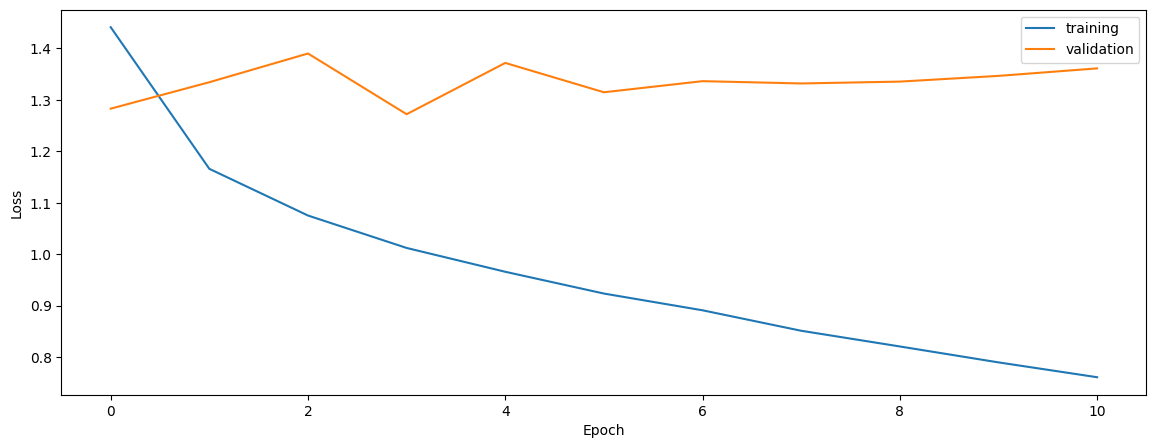

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6255484477086741
0.5106028611747382
0.4432667945785059


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5769230769230769
0.5459740019714144
0.5010586211459573


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5866550148826923
0.5537988735422655
0.5303070956411444


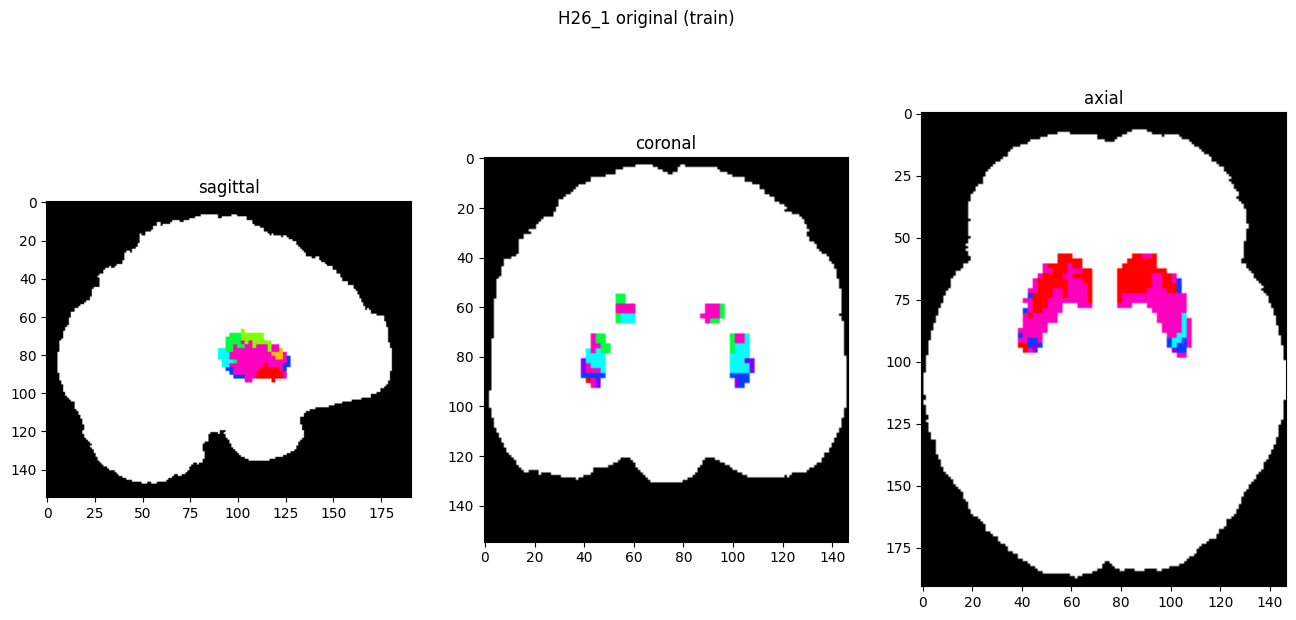

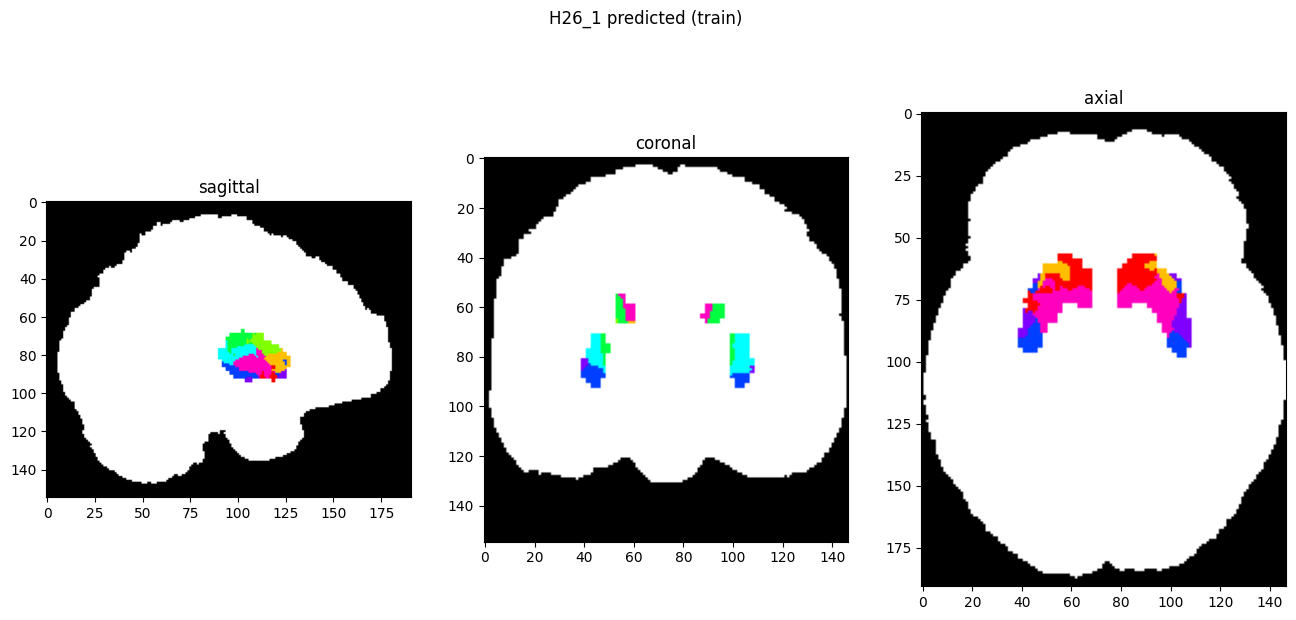

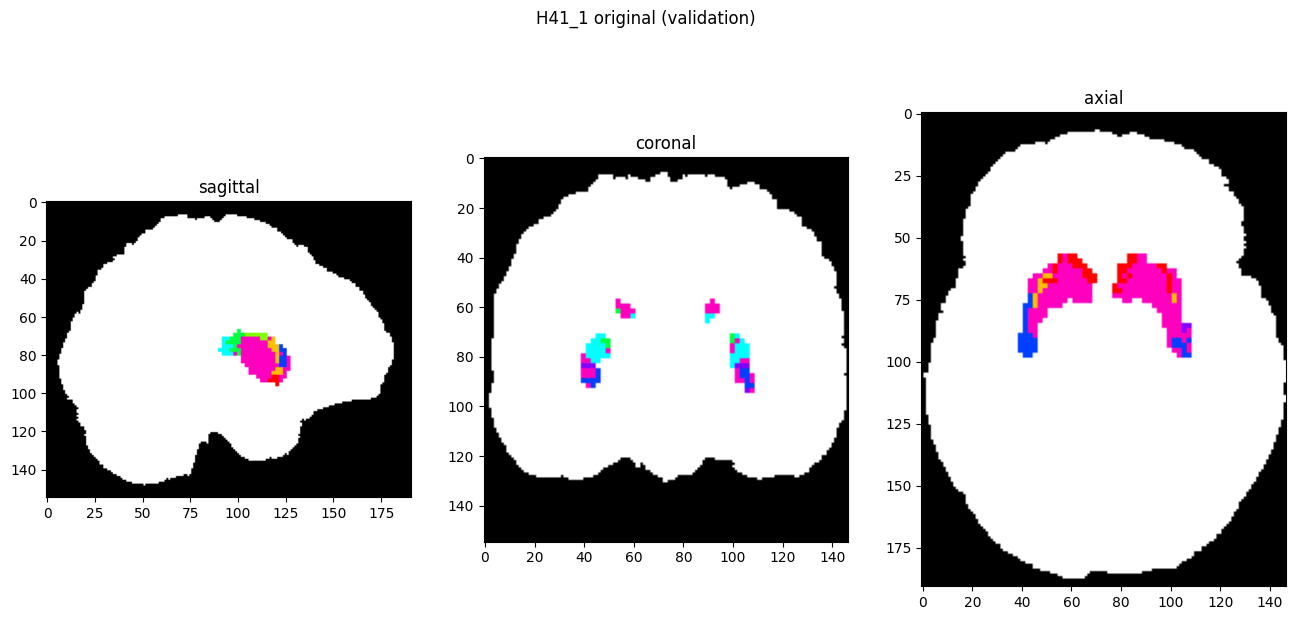

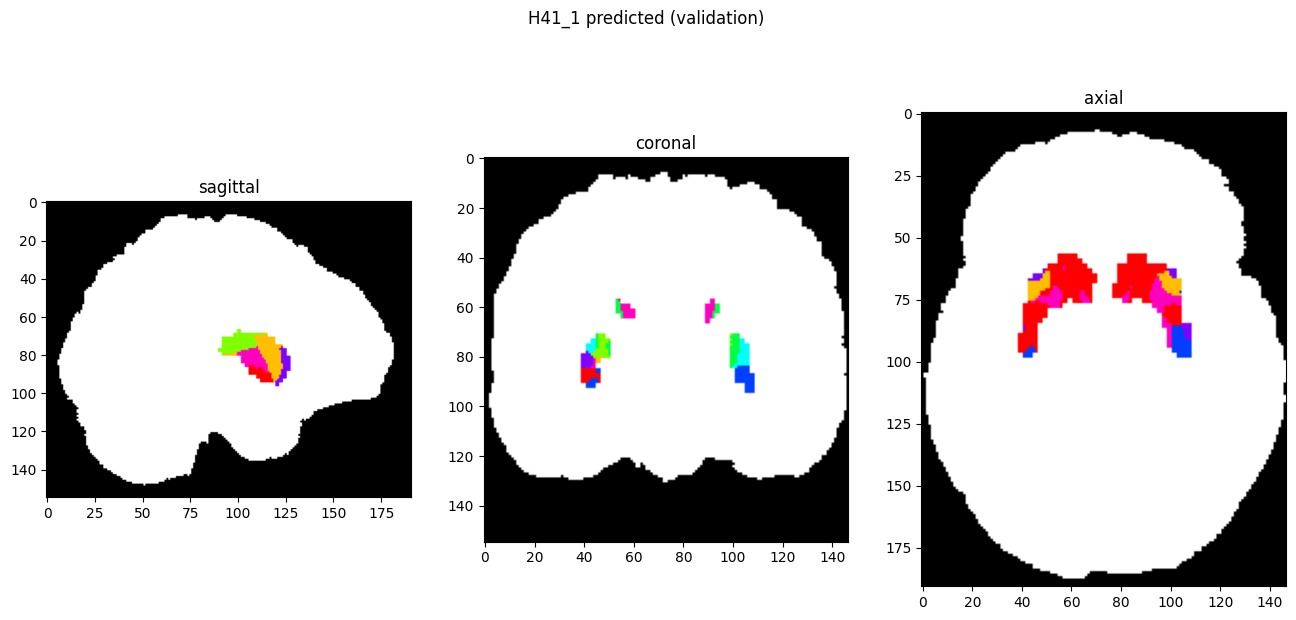

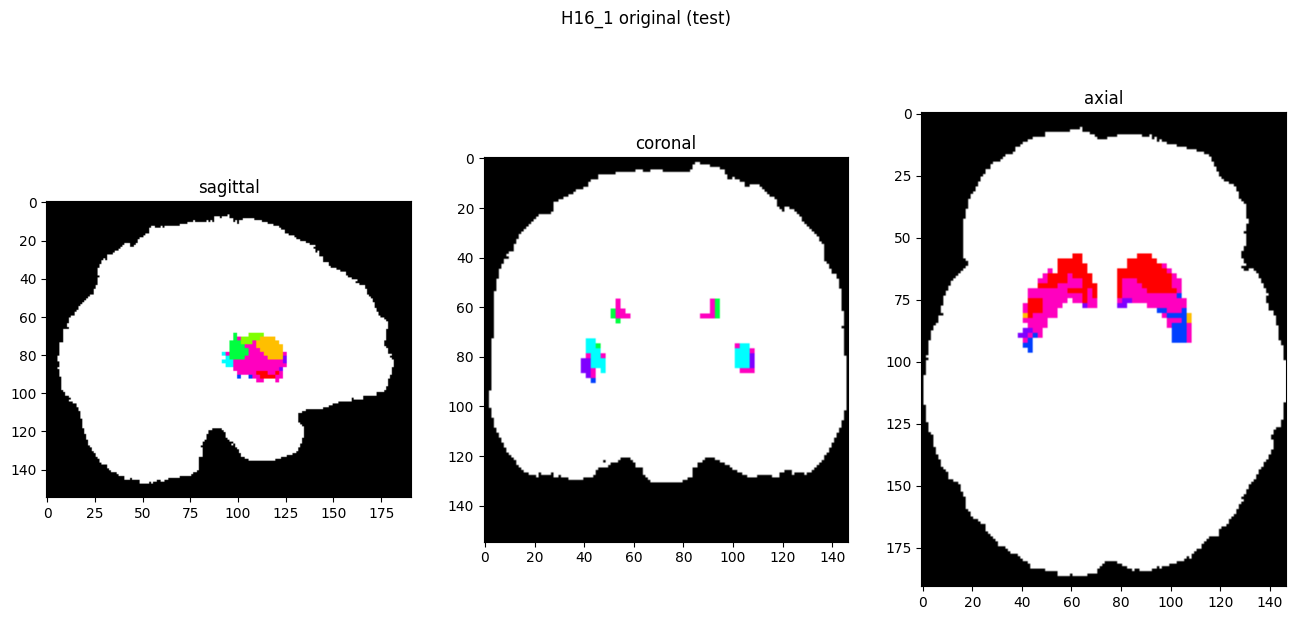

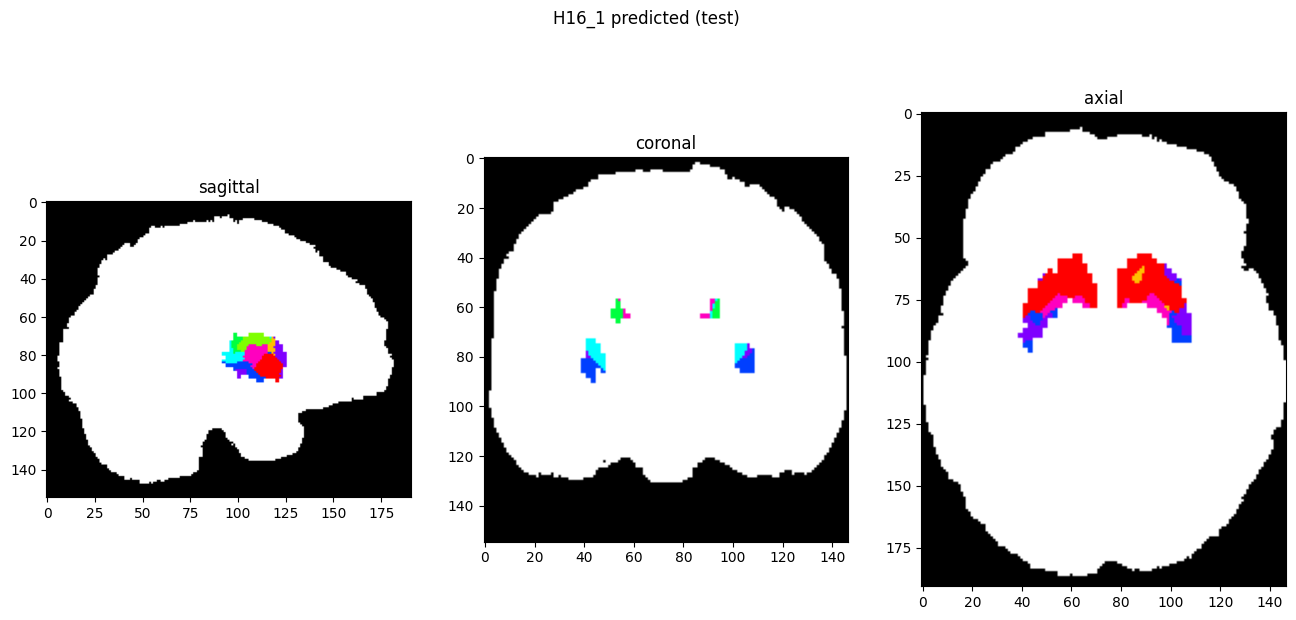

In [10]:
showResults(model, gen, threshold=0)